Connected to iblenv (Python 3.10.12)

In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [2]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [3]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.83k/3.83k [00:00<00:00, 10.4kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.83k/3.83k [00:00<00:00, 13.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.83k/3.83k [00:00<00:00, 13.4kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_trials.table.pqt: 100%|██████████| 40.4k/40.4k [00:00<00:00, 104kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.54k/7.54k [00:00<00:00, 20.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_wheel.position.npy: 100%|██████████| 5.57M/5.57

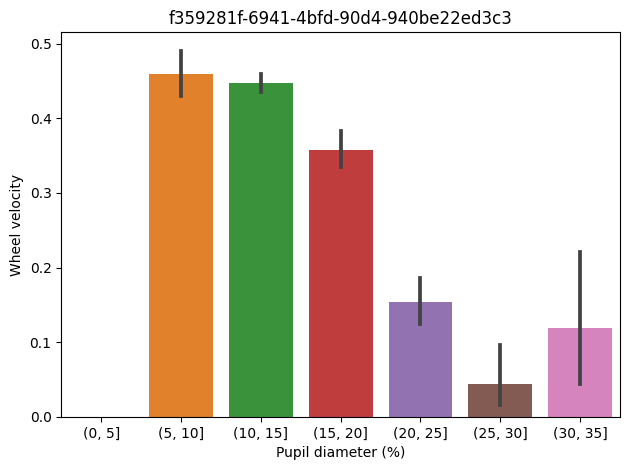

/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.5k/37.5k [00:00<00:00, 88.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 11.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.91k/6.91k [00:00<00:00, 22.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 12.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.52k/3.52k [00:00<00:00, 12.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-22/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.12M/8

ValueError: cannot convert float NaN to integer

In [4]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = list(session_trials['stimOff_times'][-1:])[0]
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    #plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [5]:
session_length

nan

In [6]:
session_trials['stimOff_times']

0      112.047028
1      115.397359
2      133.017130
3      147.066759
4      165.229542
          ...    
419           NaN
420           NaN
421           NaN
422           NaN
423           NaN
Name: stimOff_times, Length: 424, dtype: float64

In [7]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    #plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


KeyboardInterrupt: 

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


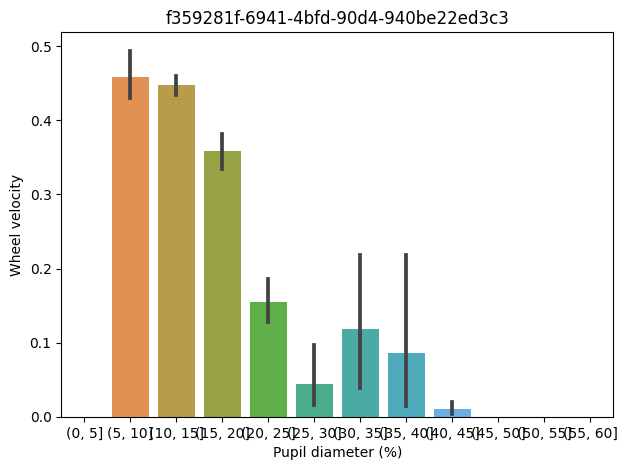

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: arange: cannot compute length

In [8]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [9]:
session_length

424

In [10]:
np.floor(session_length)

424.0

In [11]:
session_trials

,stimOff_times,intervals_bpod_0,intervals_bpod_1,goCueTrigger_times,quiescencePeriod,rewardVolume,contrastRight,response_times,probabilityLeft,choice,...,firstMovement_times,contrastLeft,intervals_0,intervals_1,signed_contrast,contrast,correct_easy,correct,response,reaction
0,112.047028,0.000000,2.614503,110.564078,0.545003,1.5,0.2500,110.992381,0.5,-1.0,...,110.768616,0.0,109.932572,112.547097,0.2500,0.2500,NaN,1.0,0.428405,0.204640
1,115.397359,3.068301,5.964802,113.917608,0.467914,1.5,0.0000,114.338312,0.5,1.0,...,114.076616,1.0,113.000899,115.897428,-1.0000,1.0000,1.0,1.0,0.420871,0.159175
2,133.017130,6.421700,23.584402,128.900525,0.615546,1.5,0.0000,131.970749,0.5,1.0,...,128.934616,1.0,116.354330,133.517162,-1.0000,1.0000,1.0,1.0,3.070340,0.034207
3,147.066759,24.080300,37.634003,145.763442,0.604984,1.5,1.0000,146.008043,0.5,-1.0,...,145.837616,0.0,134.013064,147.566856,1.0000,1.0000,1.0,1.0,0.244721,0.074294
4,165.229542,38.150900,55.796602,149.730268,0.654852,1.5,0.0625,164.174765,0.5,-1.0,...,149.921616,0.0,148.083757,165.729577,0.0625,0.0625,NaN,1.0,14.444672,0.191524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,NaN,2910.176399,2913.505402,3021.574532,0.405264,1.5,1.0000,3021.894135,0.2,-1.0,...,NaN,0.0,3020.129421,3023.458450,1.0000,1.0000,1.0,1.0,NaN,NaN
420,NaN,2914.252999,2916.701602,3024.738056,0.482396,1.5,0.1250,3025.106659,0.2,-1.0,...,NaN,0.0,3024.206052,3026.654674,0.1250,0.1250,NaN,1.0,NaN,NaN
421,NaN,2917.446199,2922.634802,3029.108190,0.417395,0.0,0.0625,3030.019397,0.2,1.0,...,NaN,0.0,3027.399277,3032.587920,0.0625,0.0625,NaN,0.0,NaN,NaN
422,NaN,2923.376499,2927.084302,3034.008027,0.601091,0.0,0.0625,3034.464031,0.2,1.0,...,NaN,0.0,3033.329622,3037.037454,0.0625,0.0625,NaN,0.0,NaN,NaN


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


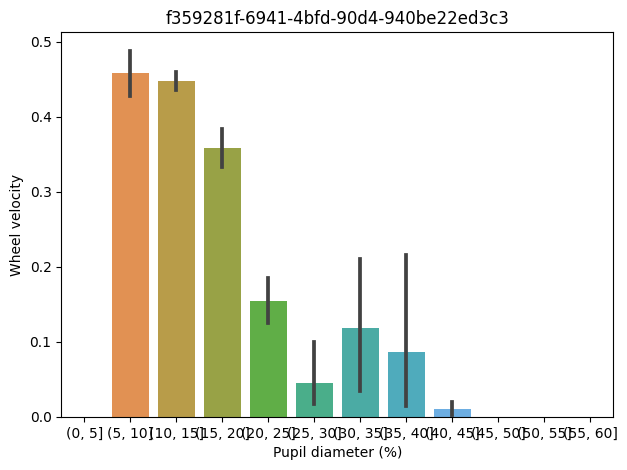

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: arange: cannot compute length

In [12]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [13]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [14]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [15]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


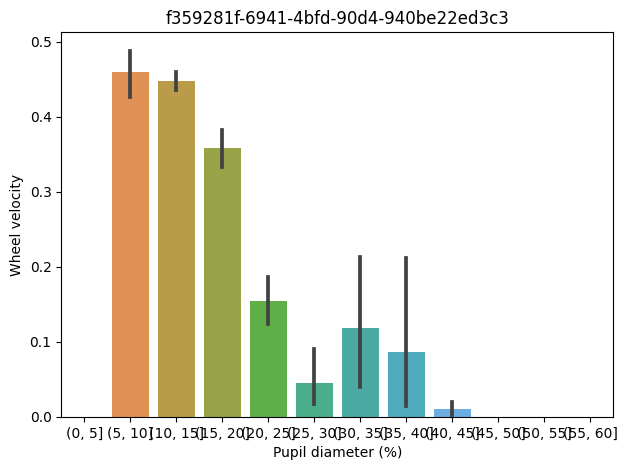

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: arange: cannot compute length

In [16]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [17]:
import pickle

In [18]:
import pickle

In [19]:
import pickle

In [20]:
import matplotlib.pyplot as plt

In [21]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [22]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


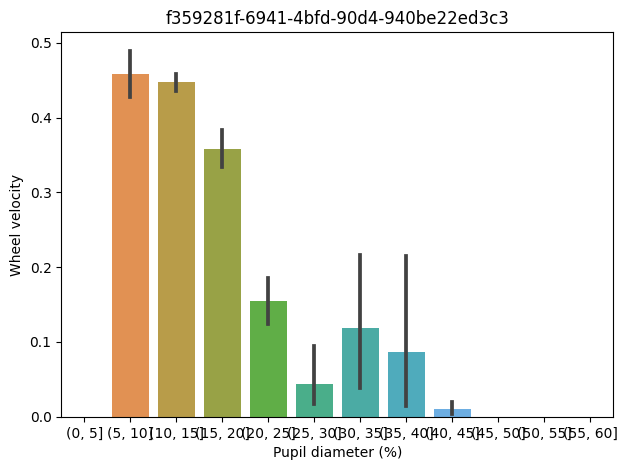

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: arange: cannot compute length

In [23]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [24]:
    session_length = len(session_trials['stimOff_times'])
    # Create a sample DataFrame with values
    data = {'Wheel times': wheel_times,
            'Wheel position': pos}

    df = pd.DataFrame(data)

    # Define the number of bins and create the bins
    bins = np.arange(0, np.floor(session_length), bin_size)
    bins = pd.cut(df['Wheel times'], bins=bins, labels=False)

In [25]:
session_length

424

Restarted iblenv (Python 3.10.12)

In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [2]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [3]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


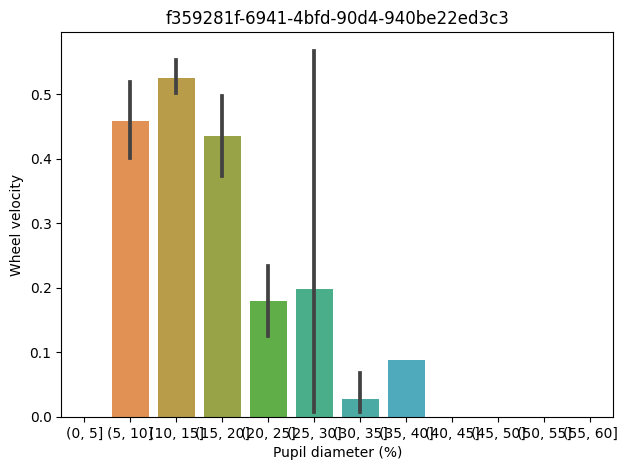

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: arange: cannot compute length

In [4]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

Restarted iblenv (Python 3.10.12)

In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [2]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [3]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


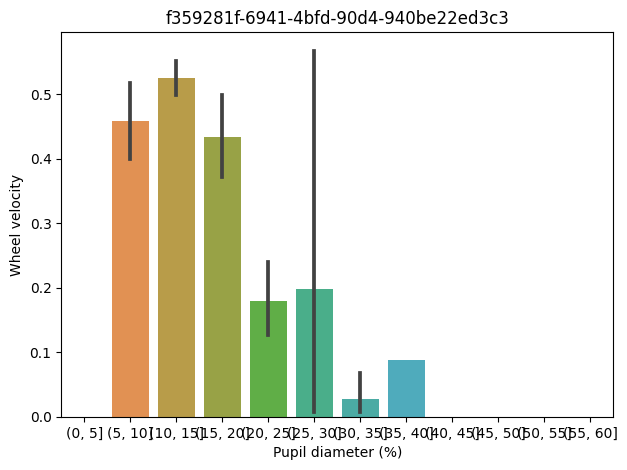

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: Bin edges must be unique: array([ 110.56397583,  113.91744045,  128.90040867,  145.76332221,
        149.73009216,  170.34999663,  174.78298662,  179.03312823,
        182.87941023,  186.59997147,  190.79631846,  212.82901497,
        216.89890794,  219.71595954,  234.91193979,  237.91557273,
        242.84511306,  246.09875433,  249.14881596,  253.77831963,
        266.82808119,  272.34486279,  277.48131576,  287.32803099,
        294.18121227,  304.2279075 ,  315.27756909,  319.53074373,
        332.21074227,  335.34759522,  338.16421353,  341.18081184,
        350.92747041,  356.38085835,  378.82658022,  387.0932868 ,
        396.27993471,  402.51327798,  409.07605497,  412.04282493,
        417.84257823,  434.66276271,  439.64579769,  451.50891126,
        462.34216116,  480.94186767,  486.24210426,  494.71159056,
        505.09528542,  510.06162207,  521.99142897,  532.0411239 ,
        535.9244022 ,  551.92743507,  555.3941217 ,  566.92780155,
        580.37379015,  584.99032845,  591.27693306,  595.40702001,
        604.59373458,  619.07335314,  623.03965647,  627.65992773,
        632.74348599,  639.92296797,  648.10968255,  656.20617282,
        660.30569616,  670.4759457 ,  684.05918724,  692.7423855 ,
        697.27213248,  714.87190566,  718.92493365,  723.65836026,
        727.48851054,  731.62143054,  740.64176175,  744.07505172,
        750.30836166,  767.07451821,  780.6409281 ,  789.65432667,
        796.25739963,  802.9370316 ,  808.2871632 ,  820.47031143,
        831.07368432,  836.23683462,  847.0866162 ,  852.1567758 ,
        857.24003409,  863.40301773,  868.47284403,  873.96952764,
        884.55276921,  902.12257872,  909.08551569,  918.10588023,
        922.36858725,  928.06881717,  933.35542179,  938.53890339,
        947.23883331,  963.68848818,  966.53850315,  982.25119839,
        992.45104497,  995.3544546 , 1002.28439487, 1013.60449608,
       1019.21726808, 1026.18410466, 1037.68385457, 1042.43744583,
       1049.62022748, 1054.6871874 , 1063.83353934, 1069.76651265,
       1074.28646061, 1085.21670081, 1100.60282871, 1105.81954032,
       1110.93629526, 1124.23233219, 1129.10257845, 1132.50247176,
       1145.43537834, 1152.09871194, 1160.11884318, 1176.18177006,
       1185.4984383 , 1196.83140489, 1199.93472786, 1210.43474442,
       1215.71801604, 1221.19776801, 1224.63135795, 1237.23069789,
       1240.19743452, 1247.14750611, 1251.86696745, 1258.14707271,
       1267.51366929, 1270.70035059, 1287.46700709, 1298.01661869,
       1308.81323892, 1320.86673345, 1324.57972878, 1328.86596678,
       1332.79960671, 1336.76601003, 1340.84933499, 1343.89949661,
       1349.24592858, 1353.26579322, 1356.49590351, 1359.62905683,
       1362.74911146, 1369.49913639, 1372.74584502, 1384.63208961,
       1390.61219154, 1404.94485813, 1412.79857268, 1416.94839099,
       1421.04471465, 1424.14807095, 1437.82790283, 1447.34801739,
       1452.04791402, 1456.87783098, 1465.76060928, 1468.87739757,
       1478.73117876, 1484.7641754 , 1490.2139637 , 1505.74367724,
       1524.24712671, 1528.51326672, 1532.52999834, 1539.71314662,
       1551.47980317, 1557.82640178, 1563.69648138, 1568.71297968,
       1574.79277164, 1579.47590328, 1585.21272954, 1589.51229954,
       1597.02898113, 1601.55879477, 1604.62545474, 1611.82883433,
       1624.01168259, 1628.84189952, 1632.25845783, 1646.35824771,
       1653.41167563, 1660.97441928, 1667.07790887, 1671.0245475 ,
       1677.40780911, 1692.44437197, 1698.71071194, 1708.84046553,
       1712.19089712, 1716.42780672, 1719.82376709, 1728.12380367,
       1732.27372197, 1743.12337023, 1746.80656854, 1753.10983815,
       1756.12340343, 1760.25642342, 1766.43963837, 1773.33961497,
       1783.94322117, 1791.89275947, 1799.44277106, 1805.28925302,
       1814.15953257, 1819.12553592, 1824.97225119, 1828.4088075 ,
       1834.39200912, 1838.60535441, 1845.98861601, 1853.00488098,
       1863.52519551, 1871.93822079, 1893.49149858, 1901.13790053,
       1904.55465882, 1908.97425015, 1915.95408543, 1923.10790331,
       1927.35751164, 1940.65384854, 1944.59042151, 1949.92358814,
       1955.9533851 , 1961.94035301, 1969.23688995, 1974.43673658,
       1983.02357781, 1989.5066961 , 1994.88642474, 1998.33654636,
       2002.64021595, 2008.98611463, 2013.90612258, 2017.73960586,
       2020.96941618, 2023.95618414, 2039.78556771, 2046.53559264,
       2049.50606223, 2054.65591386, 2063.58918711, 2069.75197077,
       2081.90475537, 2085.62161698, 2090.42200356, 2097.77196849,
       2105.4884301 , 2109.40490508, 2113.85156037, 2128.13439861,
       2135.01767688, 2140.10106849, 2144.08760313, 2149.50099507,
       2153.33741139, 2158.78380003, 2162.66741163, 2166.68360997,
       2171.8337949 , 2180.60401779, 2188.21698975, 2193.72063933,
       2206.58675259, 2216.73647085, 2223.73300446, 2231.33307771,
       2236.30291401, 2245.18272594, 2252.66941053, 2258.0658375 ,
       2269.24881909, 2275.09886736, 2281.78203231, 2289.94861557,
       2293.06913682, 2299.21832184, 2302.44863211, 2306.58191874,
       2311.45186503, 2315.61511533, 2318.50165998, 2321.76833328,
       2326.31854488, 2331.38497152, 2355.651078  , 2361.55088796,
       2368.86395658, 2376.2976798 , 2380.26771609, 2388.26398305,
       2394.71767095, 2398.51395795, 2403.28414755, 2407.53405585,
       2410.61364786, 2413.65024417, 2417.16329283, 2423.16672576,
       2427.74663439, 2434.43356563, 2439.16302597, 2449.0160739 ,
       2452.77976416, 2456.53315545, 2459.54625411, 2463.2996454 ,
       2468.23285203, 2475.87918732, 2480.72913561, 2485.61238057,
       2489.6460105 , 2495.16255879, 2499.56221878, 2505.83202507,
       2512.14902664, 2520.11556324, 2523.22835193, 2531.17865682,
       2534.54505348, 2544.9784767 , 2550.06510132, 2557.58168292,
       2562.49459158, 2566.29461154, 2577.09446478, 2581.13146104,
       2586.54441969, 2591.17765632, 2594.81102628, 2599.33124088,
       2603.61037959, 2608.71450246, 2616.19748742, 2624.58081567,
       2629.02680436, 2639.4470289 , 2642.9800089 , 2647.86022083,
       2654.04343578, 2658.57634911, 2664.67647237, 2677.61294526,
       2691.54265215, 2695.34630508, 2704.72560039, 2708.62614363,
       2717.44252857, 2721.09572988, 2724.52542021, 2730.31270809,
       2737.55891673, 2743.99543968, 2750.67533829, 2755.22508327,
       2769.30824148, 2777.29160973, 2781.89141637, 2787.32800599,
       2792.77819425, 2805.6410745 , 2809.14475743, 2815.89464904,
       2821.76072904, 2827.807191  , 2832.6407076 , 2836.82408922,
       2845.99400547, 2851.04036745, 2855.89364874, 2859.81039036,
       2867.6602053 , 2872.90664727, 2877.47339055, 2881.62667518,
       2886.2730105 , 2891.33980377, 2895.77629341, 2899.86008499,
       2910.35976825, 2914.17618657, 2918.67257022, 2929.22598144,
       2936.39246472, 2940.64250634, 2945.27590962, 2950.48902159,
       2955.48902154, 2961.77529285, 2969.33860311, 2973.47548938,
       2976.65860437, 2985.4750893 ,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [4]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    # Bin data on both axes
    bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

    #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
    #data_df = data_df.reset_index(level=[0])

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot per session
    sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
    plt.xlabel('Pupil diameter (%)')
    plt.ylabel('Wheel velocity')
    plt.title(session)

    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

In [5]:
onsets

0      110.563976
1      113.917440
2      128.900409
3      145.763322
4      149.730092
          ...    
419           NaN
420           NaN
421           NaN
422           NaN
423           NaN
Name: stimOn_times, Length: 424, dtype: float64

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


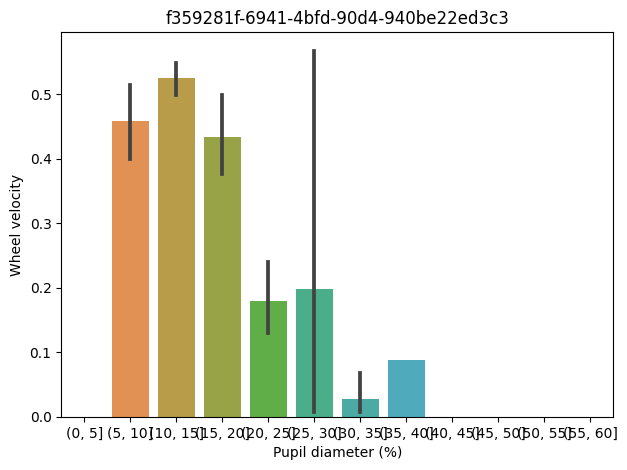

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.06k/4.06k [00:00<00:00, 14.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.98k/7.98k [00:00<00:00, 28.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.06k/4.06k [00:00<00:00, 13.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_trials.table.pqt: 100%|██████████| 42.1k/42.1k [00:00<00:00, 96.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_trials.goCueTrigger_ti

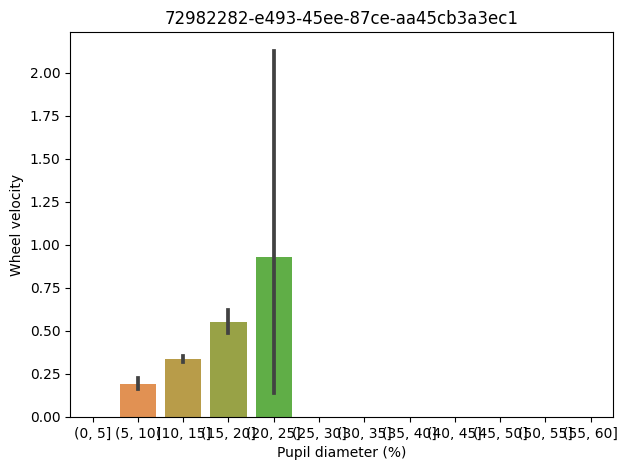

/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.18k/8.18k [00:00<00:00, 25.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.15k/4.15k [00:00<00:00, 13.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.15k/4.15k [00:00<00:00, 13.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.15k/4.15k [00:00<00:00, 13.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_trials.table.pqt: 100%|██████████| 43.0k/43.0k [00:00<00:00, 107kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_wheel.position.npy: 100%|██████████| 6.85M/6.85

ValueError: Bin edges must be unique: array([  83.6536338 ,   91.33693206,   97.15714998,  101.95696995,
        106.23664194,  112.17001521,  117.29000316,  121.47001845,
        125.37299478,  129.20294508,  133.62313635,  137.63943468,
        142.7730546 ,  146.00286492,  151.0062312 ,  155.2061445 ,
        159.55284312,  163.31923311,  167.53941105,  172.12218606,
        176.28583632,  179.45591928,  183.72239259,  187.65553257,
        190.73545788,  195.00526419,  199.36869447,  204.48524943,
        208.40169108,  211.27200402,  215.63520099,  220.58840562,
        223.73832393,  227.58503922,  231.47201715,  235.61820249,
        239.17164711,  244.90487373,  249.63783372,  253.10145399,
        258.03476061,  261.18467892,  265.21774224,  269.07095688,
        273.1546818 ,  284.3208984 ,  289.83754668,  293.52074499,
        301.65069858,  305.38759152,  309.16734684,  315.55390812,
        318.4038231 ,  324.75372138,  332.77025298,  337.3832583 ,
        341.16677991,  345.06972291,  347.99969655,  354.18644448,
        358.3198311 ,  361.48671438,  368.23597272,  371.91953766,
        376.21627461,  379.10248596,  382.21907427,  386.11598454,
        393.26906916,  396.33266277,  399.34916109,  403.54907439,
        407.71899069,  411.06892233,  414.56890563,  417.99896259,
        421.51891056,  424.96566585,  428.9154375 ,  432.88217412,
        436.65183045,  444.55174038,  448.21857366,  454.41848694,
        459.28163391,  463.85137689,  468.56843847,  472.5014118 ,
        476.74792044,  481.03139205,  485.38132368,  489.43461831,
        492.96476526,  498.01769325,  501.3641919 ,  507.46788147,
        510.81737982,  517.33082841,  521.01769302,  525.33086166,
        530.14721331,  534.7505196 ,  538.44708324,  543.6136332 ,
        546.93026817,  550.16667783,  554.23030476,  562.88330604,
        566.56677099,  569.87983965,  573.56333793,  577.29669789,
        582.38325585,  586.82981115,  590.66619414,  594.89960409,
        599.86637403,  602.76278436,  606.51660894,  611.3625243 ,
        615.7494189 ,  618.81261255,  623.13251385,  628.17944244,
        631.12911411,  636.3956874 ,  639.87893904,  643.74555234,
        646.998627  ,  650.51234226,  655.19540724,  658.56187056,
        662.76215049,  665.91203547,  668.9984268 ,  672.9813618 ,
        676.38152175,  682.19804004,  686.99825997,  691.9817949 ,
        695.58163488,  698.91483486,  702.71135517,  707.26123347,
        711.84800808,  716.04435507,  720.43101636,  724.04428833,
        728.69758962,  733.87737159,  736.89420321,  740.86417284,
        745.64429478,  749.46067977,  753.2310027 ,  758.39695272,
        762.04725432,  766.44711429,  770.67699126,  774.27696456,
        777.18024087,  780.16317588,  785.24670081,  789.42994911,
        792.24333441,  795.80994438,  799.4097177 ,  802.31279403,
        806.08008393,  810.07971726,  814.2099042 ,  818.47627752,
        822.94289748,  827.19580548,  831.16290873,  835.80911073,
        840.442614  ,  843.89573532,  847.97926026,  852.11254689,
        855.19567188,  858.30906051,  862.94566347,  880.44214698,
        884.42531529,  888.42538191,  894.07871652,  897.11204649,
        901.60843014,  919.77824631,  925.99495791,  929.85807156,
        934.72475151,  938.24146647,  941.82457479,  945.34452276,
        948.42801438,  951.8108094 ,  957.19467096,  960.84113961,
        964.69388763,  969.06081756,  973.22423451,  977.19050451,
        985.77381276,  990.26036406,  995.66032401,  999.07701564,
       1003.55706759, 1006.9102989 , 1011.57696552, 1014.69005418,
       1017.96002715, 1023.2899941 , 1027.27672872, 1030.98975738,
       1035.04338531, 1039.6263603 , 1042.67315559, 1045.65945693,
       1050.40968186, 1054.22283384, 1059.7093518 , 1063.52287041,
       1067.20596873, 1087.67238855, 1092.94262814, 1096.47230847,
       1099.73898177, 1103.90546508, 1107.97195839, 1111.10537835,
       1117.82227326, 1121.7718116 , 1132.37488452, 1136.33825481,
       1140.60489477, 1156.92169626, 1162.2077676 , 1167.80444121,
       1174.05441615, 1179.82093944, 1183.78790937, 1190.65778898,
       1196.10411096, 1200.84097056, 1204.9571589 , 1210.09051218,
       1213.28719248, 1216.45680882, 1221.85666878, 1225.24026372,
       1228.95345903, 1232.40694698, 1235.59016196, 1239.54030024,
       1243.33658724, 1247.57319687, 1251.45324216, 1255.31985546,
       1260.07308009, 1264.33648704, 1269.73997997, 1274.58646194,
       1279.22266494, 1298.57242977, 1302.66928671, 1306.17220305,
       1314.88569828, 1318.32265455, 1323.05224821, 1326.52190121,
       1331.13537315, 1335.18533478, 1339.28869107, 1343.4686397 ,
       1346.85513435, 1351.40157966, 1355.11860792, 1358.66838624,
       1361.73821256, 1366.5683295 , 1370.72144748, 1374.78494109,
       1379.38468107, 1382.58442773, 1386.667986  , 1390.78440765,
       1394.76777594, 1398.55443057, 1402.31772087, 1405.87096551,
       1408.73807877, 1412.63792208, 1416.55076409, 1421.05411371,
       1425.43397568, 1442.80397184, 1447.22033016, 1452.92006013,
       1457.50350174, 1460.81670372, 1464.38644671, 1468.83703494,
       1472.83343526, 1477.95328989, 1481.48643654, 1485.95292318,
       1493.09980842, 1497.13657137, 1500.31948638, 1504.036248  ,
       1509.34974993, 1512.41964291, 1515.86943123, 1519.61595654,
       1522.84923318, 1526.19919815, 1529.64905313, 1533.05231277,
       1537.7655414 , 1542.04894635, 1546.48206966, 1552.28578923,
       1557.63192123, 1561.9817862 , 1566.41877579, 1581.08204265,
       1585.2851223 , 1589.53506393, 1593.26515755, 1597.95188883,
       1601.18506548, 1605.36824712, 1608.99795078, 1613.23126074,
       1617.88122903, 1627.1146056 , 1631.13427026, 1635.23459352,
       1638.46777017, 1642.51423215, 1646.25092511, 1649.2307271 ,
       1653.28435503, 1661.6674833 , 1666.30058661, 1669.56712659,
       1672.8803619 , 1676.38357821, 1680.96678651, 1685.11710477,
       1689.93308979, 1693.13343639, 1697.69694666, 1700.78043828,
       1704.79986963, 1708.39634328, 1712.88312789, 1715.97985152,
       1720.36301316, 1723.63331943, 1733.28315435, 1738.266156  ,
       1742.37947796, 1745.64935094, 1750.53222927, 1754.56569255,
       1758.14910084, 1761.54936078, 1764.96255276, 1769.51556408,
       1773.58215738, 1777.04547768, 1780.39900896, 1783.56542562,
       1786.74854061, 1790.3622792 , 1801.17873078, 1806.2820204 ,
       1810.19532903, 1813.49489904, 1823.99771532, 1828.24832355,
       1838.02777884, 1841.51109714, 1862.33084829, 1866.91425657,
       1871.19736155, 1875.0608085 , 1878.76057182, 1881.89752476,
       1885.7940684 , 1889.06067504, 1911.04357653, 1916.24358981,
       1919.9599848 , 1923.06340776, 1927.31001639, 1930.69314471,
       1934.26352097, 1939.06010793, 1942.44313626, 1953.52616118,
       1956.62601783, 1959.79276779, 1962.96248412, 1970.9592177 ,
       1974.262554  , 1977.62938395, 1980.87609258, 1984.79226759,
       1988.06260719, 1992.61231884, 1995.75893748, 1999.79570043,
       2002.90872243, 2006.99214738, 2011.49543034, 2014.895157  ,
       2019.22545726, 2022.24495528, 2029.66181352, 2032.8946902 ,
       2036.25862044, 2040.42843675, 2043.57835506, 2047.29461673,
       2050.54139202, 2057.95838358, 2063.06110659, 2071.09443651,
       2076.49116345, 2082.55749009, 2091.3578433 , 2094.55745664,
       2097.81073128, 2102.22418989, 2108.71027455, 2112.11086779,
       2115.5440911 , 2120.92728606, 2124.22382304, 2127.4935627 ,
       2130.82682934, 2133.92378628, 2137.24352094, 2141.35677624,
       2146.30681452, 2150.6932425 , 2154.62641581, 2161.52639241,
       2164.87309104, 2169.50642766, 2173.20669093, 2176.35620928,
       2193.20982375, 2207.62261566, 2225.30564718, 2235.65877843,
       2245.0418067 , 2282.50809303, 2293.29111462, 2314.85455806,
       2337.60751587, 2341.40723586, 2345.14019586, 2349.47076276,
       2352.74050242, 2357.17049271, 2361.52352403, 2382.25651719,
       2391.48986043, 2398.63984536, 2406.08640063, 2410.0029756 ,
       2422.33944183, 2425.75260048, 2429.55258711, 2435.05243707,
       2439.40593501, 2446.70257194, 2450.45529663, 2458.76896518,
       2466.78536346, 2487.28827963, 2494.08829956, 2506.42169943,
       2540.5675845 , 2563.05360234, 2575.88361921, 2619.6330105 ,
       2624.08619847, 2687.99880657, 2691.55188456, 2699.86508649,
       2721.64827462, 2725.88508423, 2767.91731392, 2831.37993369,
       2837.41636332,           nan,           nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [6]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    if np.sum(np.isnan(onsets)) < 5:
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        # Bin data on both axes
        bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
        bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
        data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

        #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
        #data_df = data_df.reset_index(level=[0])

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot per session
        sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
        plt.xlabel('Pupil diameter (%)')
        plt.ylabel('Wheel velocity')
        plt.title(session)

        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()

In [7]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    #if np.sum(np.isnan(onsets)) < 5:
    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        # Bin data on both axes
        bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
        bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
        data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

        #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
        #data_df = data_df.reset_index(level=[0])

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot per session
        sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
        plt.xlabel('Pupil diameter (%)')
        plt.ylabel('Wheel velocity')
        plt.title(session)

        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()

SyntaxError: incomplete input (<ipython-input-7-55d4054eb995>, line 63)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


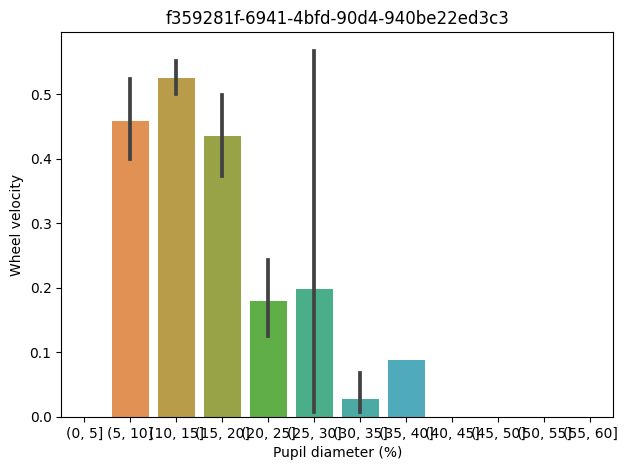

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d32876dd-8303-4720-8e7e-20678dc2fd71


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


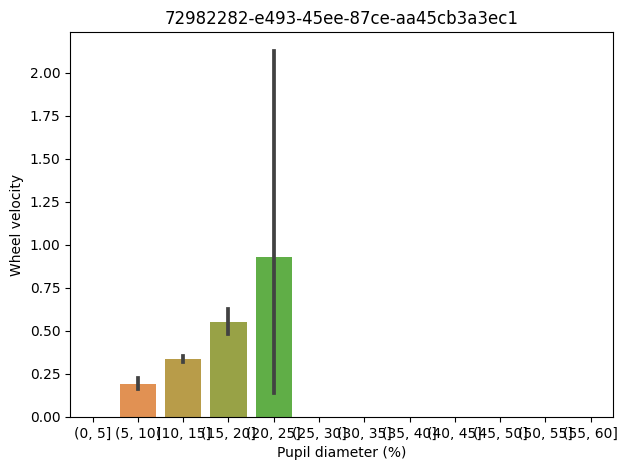

local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:05<00:00, 6.34MB/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:12<00:00, 3.11MB/s]


288bfbf3-3700-4abe-b6e4-130b5c541e61


/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.42k/9.42k [00:00<00:00, 33.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.78k/4.78k [00:00<00:00, 16.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.78k/4.78k [00:00<00:00, 17.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.78k/4.78k [00:00<00:00, 13.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_trials.table.pqt: 100%|██████████| 48.6k/48.6k [00:00<00:00, 110kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-25/001/alf/_ibl_wheel.position.npy: 100%|██████████| 6.66M/6.66

fc43390d-457e-463a-9fd4-b94a0a8b48f5


/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.98k/8.98k [00:00<00:00, 30.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.table.pqt: 100%|██████████| 46.8k/46.8k [00:00<00:00, 115kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.55k/4.55k [00:00<00:00, 15.4kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.55k/4.55k [00:00<00:00, 15.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.55k/4.55k [00:00<00:00, 14.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_wheel.position.npy: 100%|████

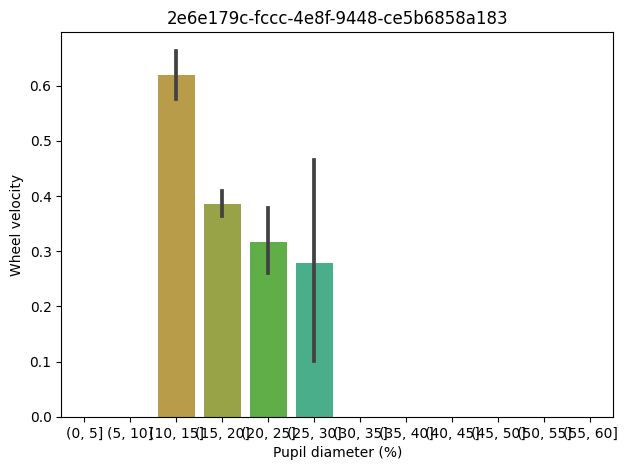

/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 12.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 14.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.78k/7.78k [00:00<00:00, 27.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.3k/41.3k [00:00<00:00, 107kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 13.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS051/2021-05-11/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.45M/5.45M [00:02<00:00, 2.

0a018f12-ee06-4b11-97aa-bbbff5448e9f


/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.25k/4.25k [00:00<00:00, 13.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.37k/8.37k [00:00<00:00, 25.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.25k/4.25k [00:00<00:00, 13.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.table.pqt: 100%|██████████| 44.3k/44.3k [00:00<00:00, 91.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.25k/4.25k [00:00<00:00, 12.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.26M/6.26M [00:06<00:00,

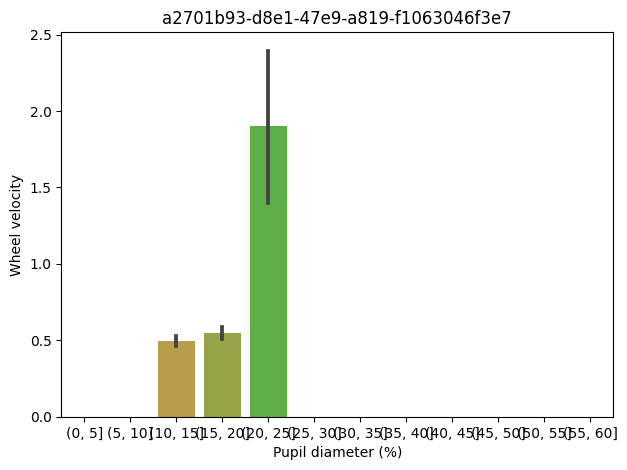

/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.6k/38.6k [00:00<00:00, 88.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.60k/3.60k [00:00<00:00, 11.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.60k/3.60k [00:00<00:00, 11.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.07k/7.07k [00:00<00:00, 25.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.60k/3.60k [00:00<00:00, 11.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.78M/4.78M [00:01<00:00, 3.28MB/s]
/Us

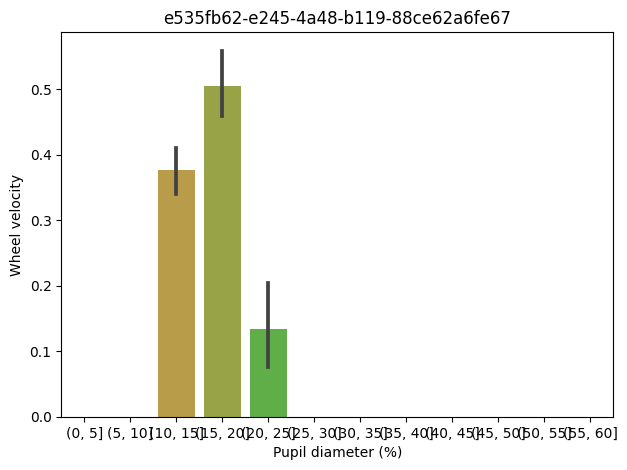

/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.22k/5.22k [00:00<00:00, 18.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.3k/10.3k [00:00<00:00, 31.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.22k/5.22k [00:00<00:00, 19.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.22k/5.22k [00:00<00:00, 17.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 52.3k/52.3k [00:00<00:00, 123kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.50M/7.50M [00:03<00:00, 2.49MB/s]
/Use

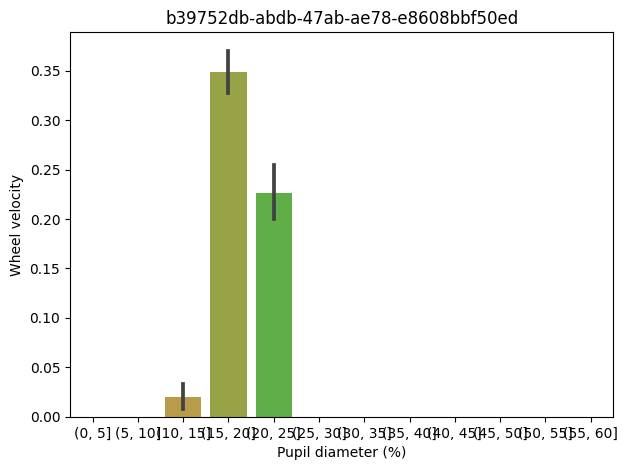

/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.63k/3.63k [00:00<00:00, 11.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.63k/3.63k [00:00<00:00, 12.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.14k/7.14k [00:00<00:00, 23.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_trials.table.pqt: 100%|██████████| 38.8k/38.8k [00:00<00:00, 82.4kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.63k/3.63k [00:00<00:00, 11.8kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.07M/7.07M [00:01<00:00, 4.08MB/s]
/

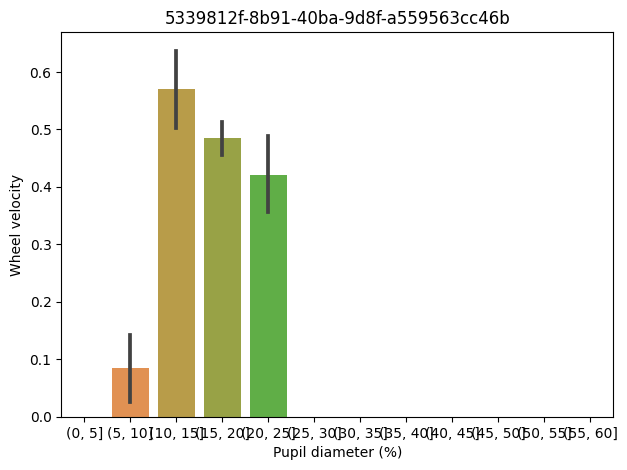

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


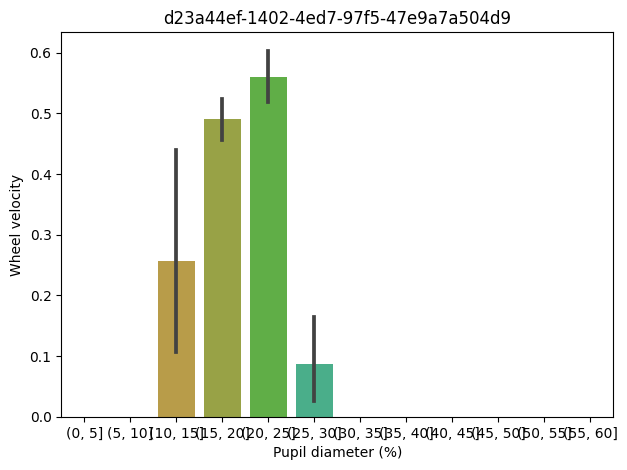

/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.24k/8.24k [00:00<00:00, 28.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.18k/4.18k [00:00<00:00, 14.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 43.3k/43.3k [00:00<00:00, 106kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.18k/4.18k [00:00<00:00, 12.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.18k/4.18k [00:00<00:00, 14.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-15/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.58M/8.58M [00:03<00:00, 2.44MB/s]
/Use

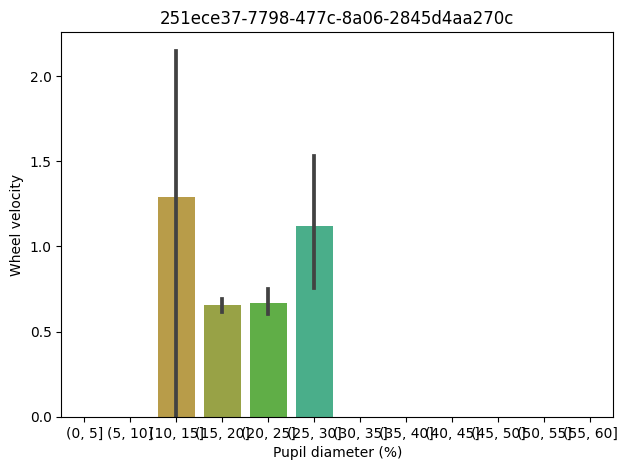

/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 15.4kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.table.pqt: 100%|██████████| 53.0k/53.0k [00:00<00:00, 121kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 17.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 16.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 10.6k/10.6k [00:00<00:00, 36.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL015/2022-02-21/002/alf/_ibl_wheel.position.npy: 100%|██████████| 4.38M/4.38M [00:01<00:

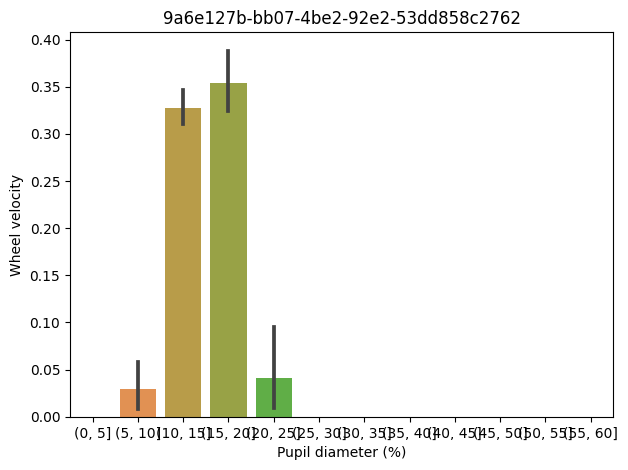

/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 10.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.6k/37.6k [00:00<00:00, 95.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 11.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.94k/6.94k [00:00<00:00, 24.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.54k/3.54k [00:00<00:00, 11.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL016/2022-01-17/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.32M/4.32M [00:01<00

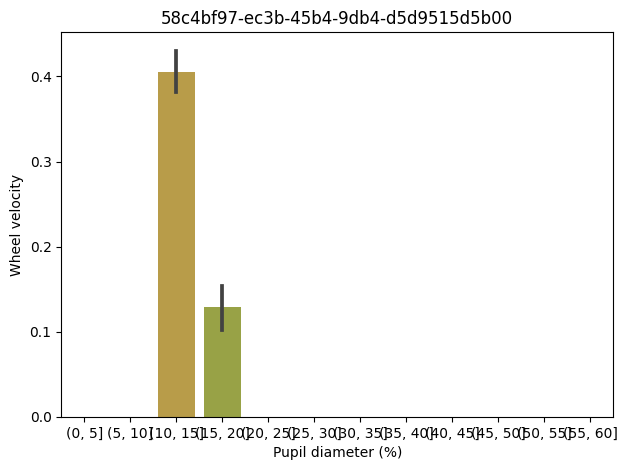

/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 36.1k/36.1k [00:00<00:00, 91.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 10.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 10.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.54k/6.54k [00:00<00:00, 23.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.34k/3.34k [00:00<00:00, 10.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-09/001/alf/_ibl_wheel.position.npy: 100%|██████████| 4.00M/4.00M [00:01<00

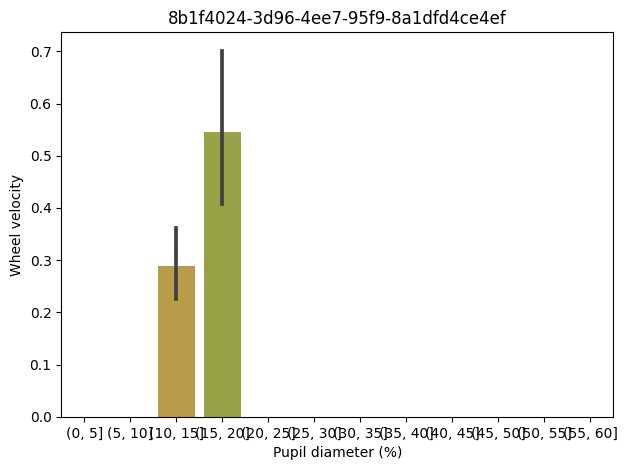

/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 6.83k/6.83k [00:00<00:00, 22.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.48k/3.48k [00:00<00:00, 11.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.48k/3.48k [00:00<00:00, 11.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_trials.table.pqt: 100%|██████████| 37.2k/37.2k [00:00<00:00, 87.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.48k/3.48k [00:00<00:00, 11.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/hausserlab/Subjects/PL017/2021-11-15/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.57M/3.57M [00:01<00

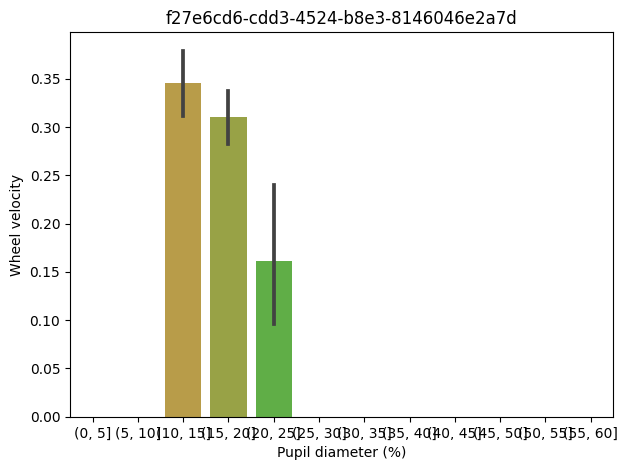

/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.15k/9.15k [00:00<00:00, 31.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.64k/4.64k [00:00<00:00, 16.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.64k/4.64k [00:00<00:00, 16.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.64k/4.64k [00:00<00:00, 16.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 47.6k/47.6k [00:00<00:00, 124kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-20/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 6.

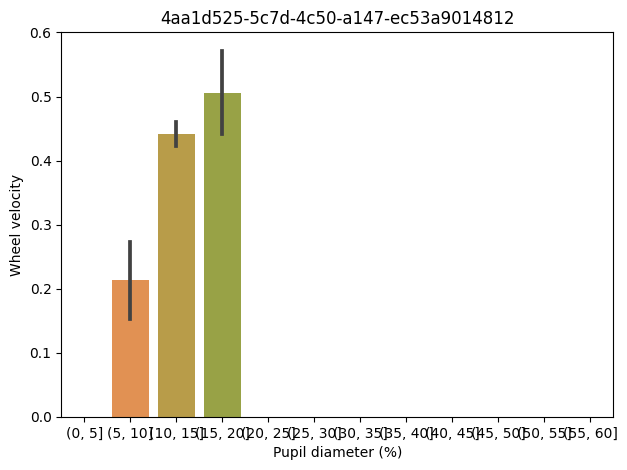

/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_trials.table.pqt: 100%|██████████| 39.2k/39.2k [00:00<00:00, 101kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.67k/3.67k [00:00<00:00, 13.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.67k/3.67k [00:00<00:00, 9.54kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.67k/3.67k [00:00<00:00, 12.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.22k/7.22k [00:00<00:00, 22.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mainenlab/Subjects/ZFM-01936/2021-01-22/002/alf/_ibl_wheel.position.npy: 100%|██████████| 5.20

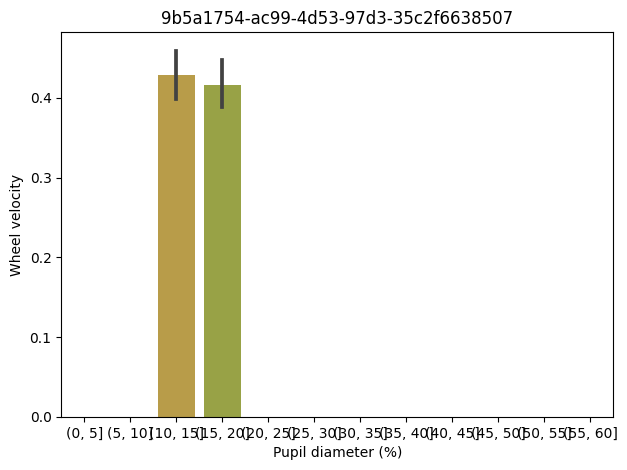

/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.66k/7.66k [00:00<00:00, 27.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_trials.table.pqt: 100%|██████████| 40.9k/40.9k [00:00<00:00, 65.2kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 14.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 12.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.90k/3.90k [00:00<00:00, 12.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_053/2020-11-11/001/alf/_ibl_wheel.position.npy: 10

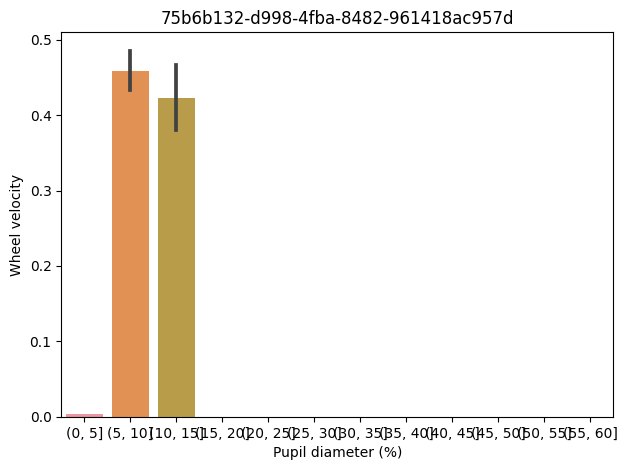

/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 12.0k/12.0k [00:00<00:00, 42.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 16.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 19.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.06k/6.06k [00:00<00:00, 18.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_trials.table.pqt: 100%|██████████| 59.0k/59.0k [00:00<00:00, 142kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-08/001/alf/_ibl_wheel.timestamps.npy: 1

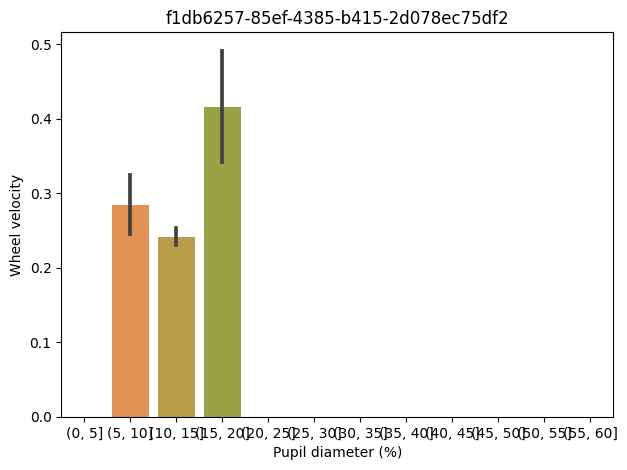

/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 7.72k/7.72k [00:00<00:00, 25.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 7.72k/7.72k [00:00<00:00, 26.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 72.9k/72.9k [00:00<00:00, 153kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 7.72k/7.72k [00:00<00:00, 25.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 15.3k/15.3k [00:00<00:00, 49.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/mrsicflogellab/Subjects/SWC_058/2020-12-09/001/alf/_ibl_wheel.position.npy: 100

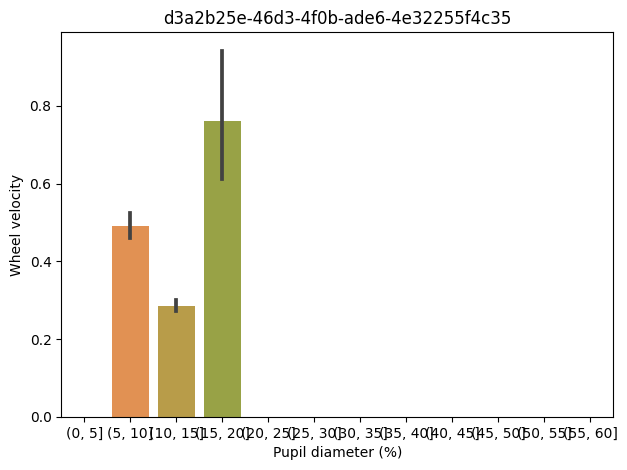

/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.14k/9.14k [00:00<00:00, 32.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.63k/4.63k [00:00<00:00, 15.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.63k/4.63k [00:00<00:00, 15.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.63k/4.63k [00:00<00:00, 14.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_trials.table.pqt: 100%|██████████| 47.5k/47.5k [00:00<00:00, 119kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-09/002/alf/_ibl_wheel.timestamps.

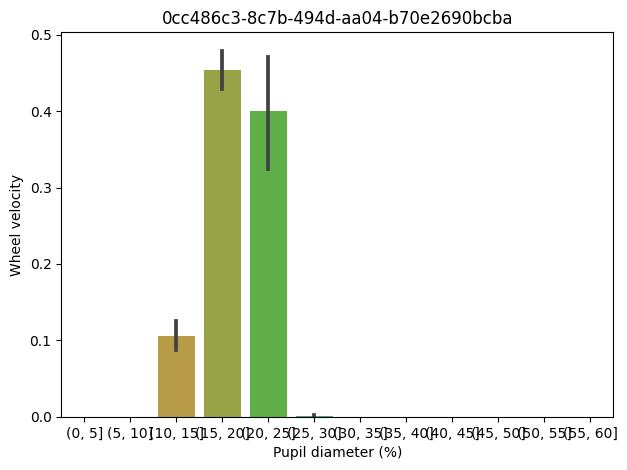

/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_trials.table.pqt: 100%|██████████| 38.3k/38.3k [00:00<00:00, 94.1kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 8.43kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 11.3kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.01k/7.01k [00:00<00:00, 23.9kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 3.57k/3.57k [00:00<00:00, 9.53kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-10/003/alf/_ibl_wheel.position.n

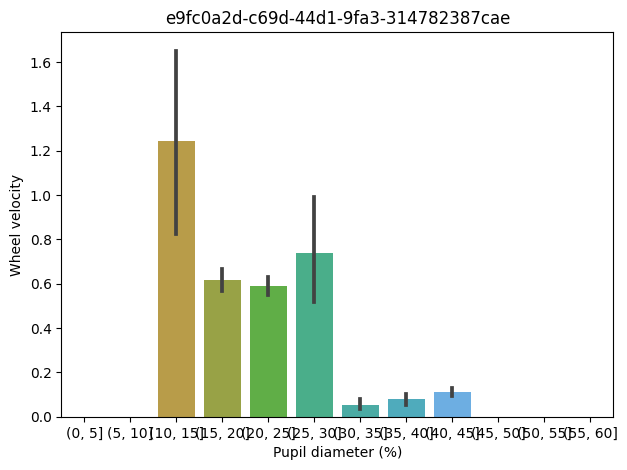

/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.4k/58.4k [00:00<00:00, 145kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 5.95k/5.95k [00:00<00:00, 19.7kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 11.8k/11.8k [00:00<00:00, 40.6kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.95k/5.95k [00:00<00:00, 18.0kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 5.95k/5.95k [00:00<00:00, 20.5kB/s]
/Users/ineslaranjeira/Downloads/FlatIron/wittenlab/Subjects/ibl_witten_29/2021-06-19/001/alf/_ibl_wheel.position.np

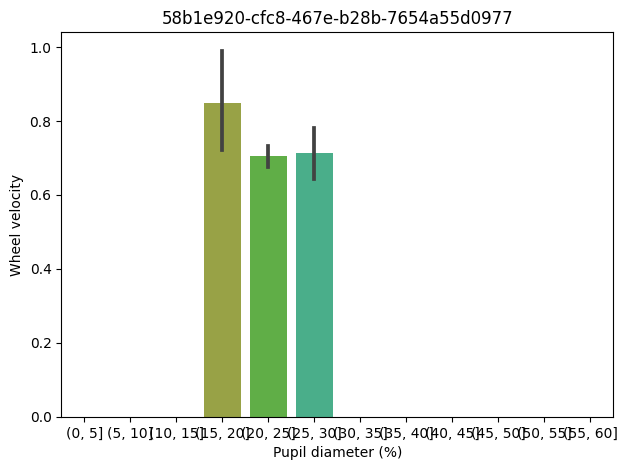

In [8]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    #if np.sum(np.isnan(onsets)) < 5:
    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        # Bin data on both axes
        bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
        bin_edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
        data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

        #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
        #data_df = data_df.reset_index(level=[0])

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot per session
        sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
        plt.xlabel('Pupil diameter (%)')
        plt.ylabel('Wheel velocity')
        plt.title(session)

        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

In [9]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [10]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [11]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


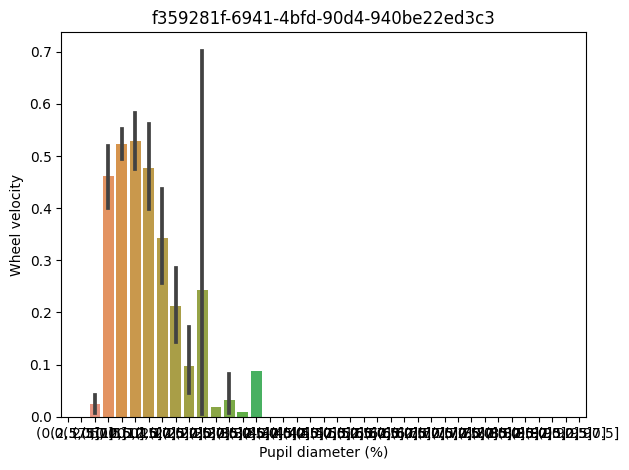

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d32876dd-8303-4720-8e7e-20678dc2fd71


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


KeyboardInterrupt: 

In [12]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    #if np.sum(np.isnan(onsets)) < 5:
    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        # Bin data on both axes
        bin_edges = np.arange(0, 100, 2.5)
        data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

        #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
        #data_df = data_df.reset_index(level=[0])

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot per session
        sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
        plt.xlabel('Pupil diameter (%)')
        plt.ylabel('Wheel velocity')
        plt.title(session)

        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


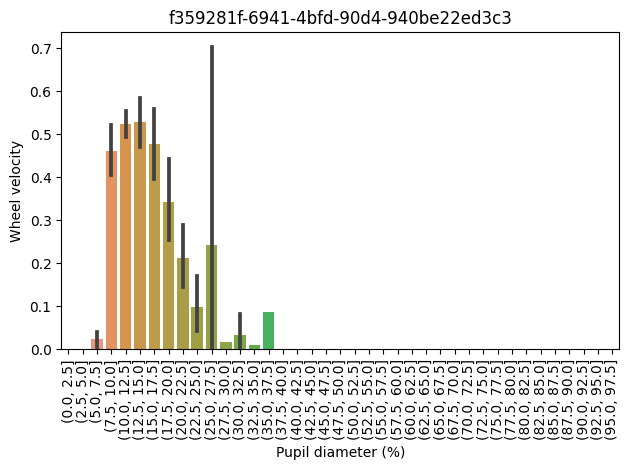

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d32876dd-8303-4720-8e7e-20678dc2fd71


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


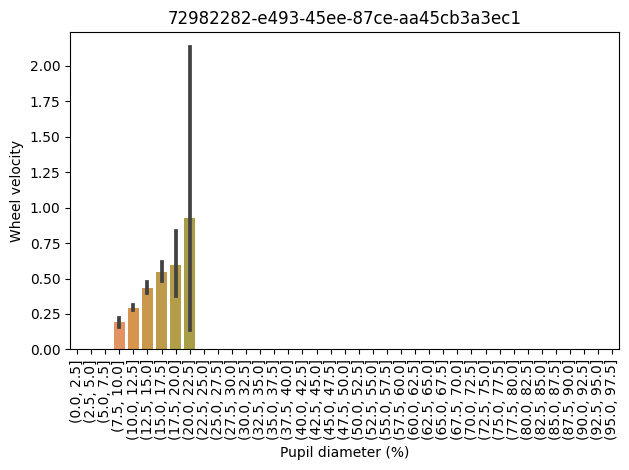

local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:30<00:00, 1.21MB/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:06<00:00, 5.50MB/s]


288bfbf3-3700-4abe-b6e4-130b5c541e61


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


fc43390d-457e-463a-9fd4-b94a0a8b48f5


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


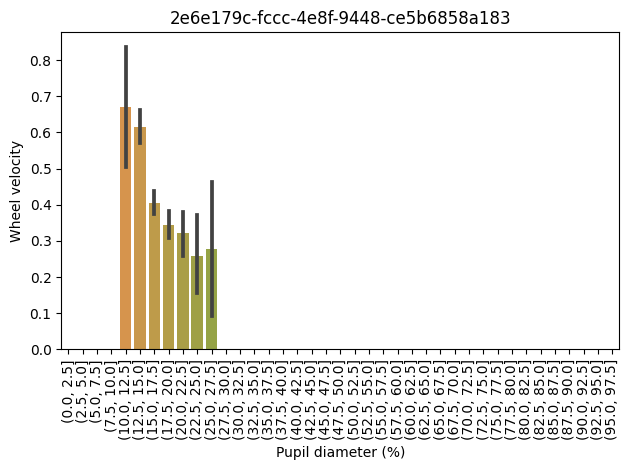

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


0a018f12-ee06-4b11-97aa-bbbff5448e9f


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


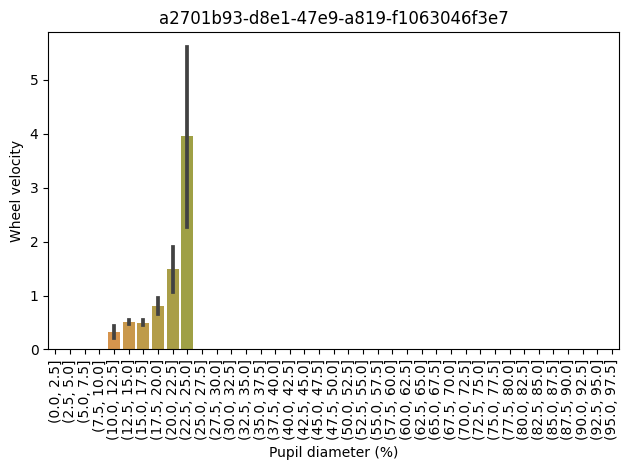

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


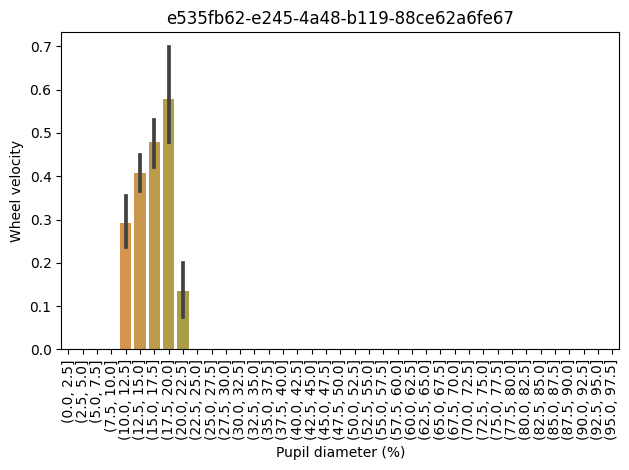

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


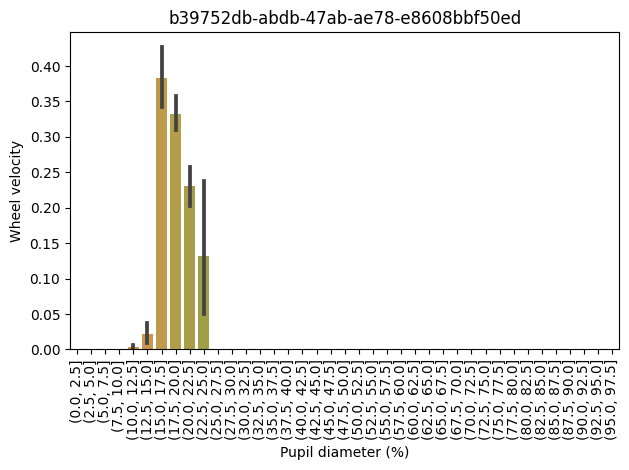

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


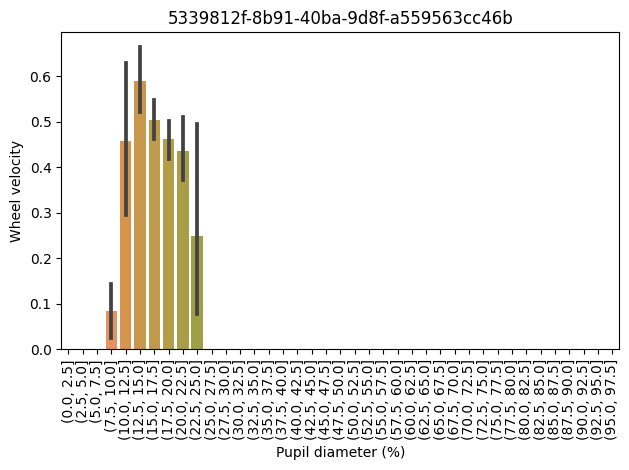

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


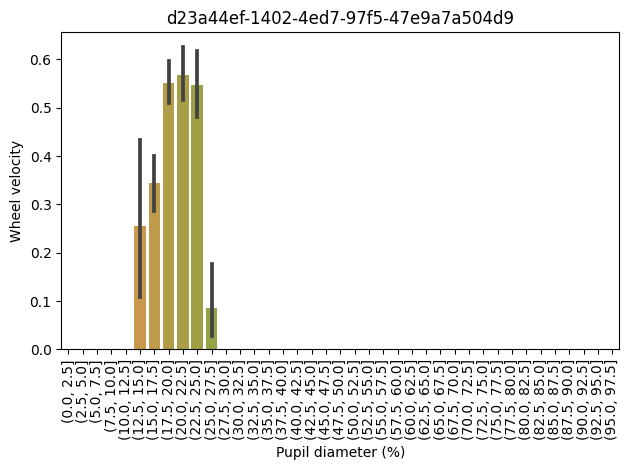

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


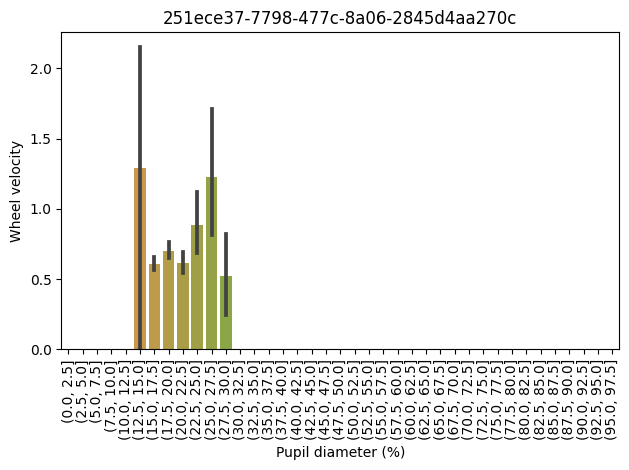

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


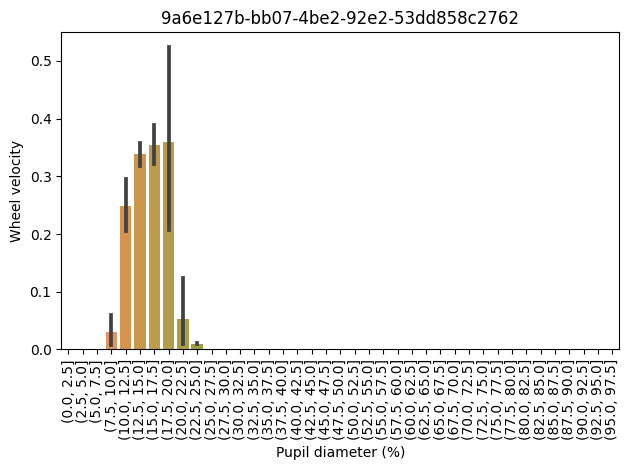

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


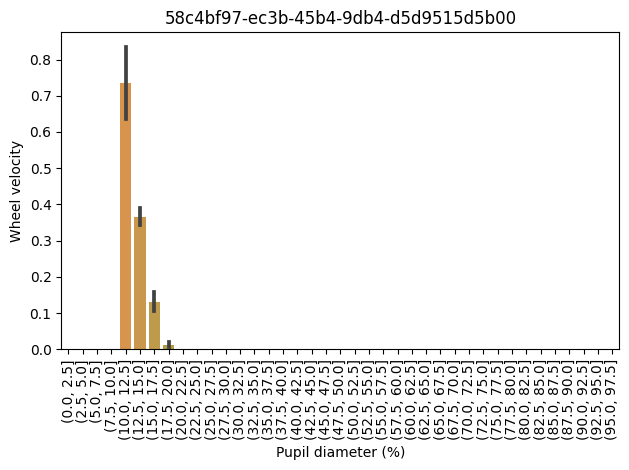

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


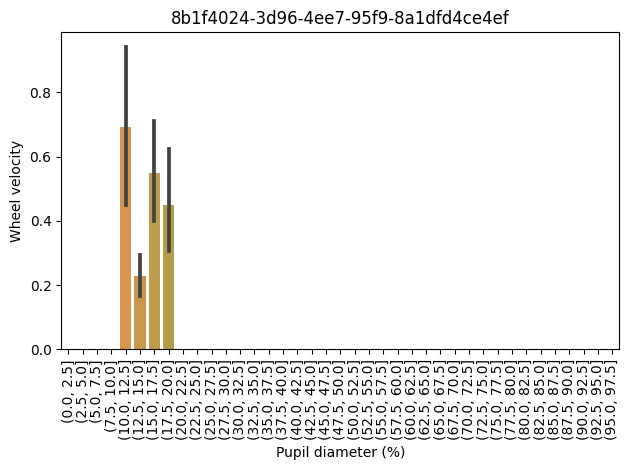

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


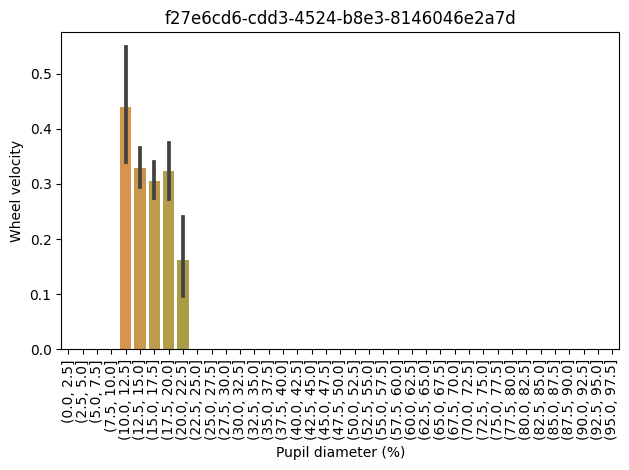

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


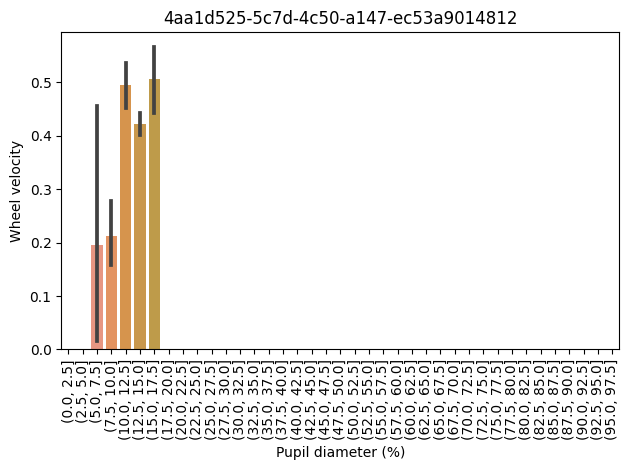

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


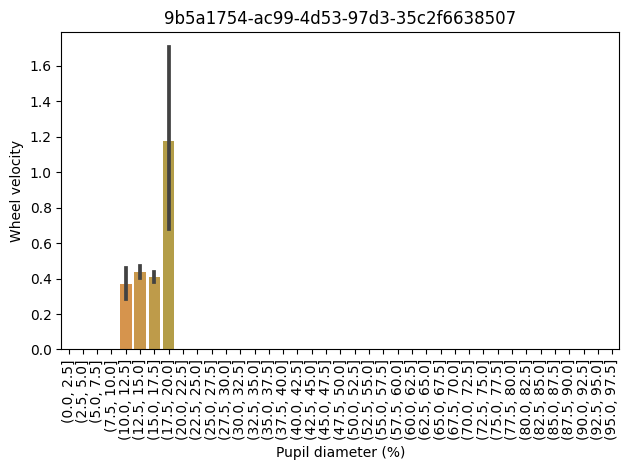

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


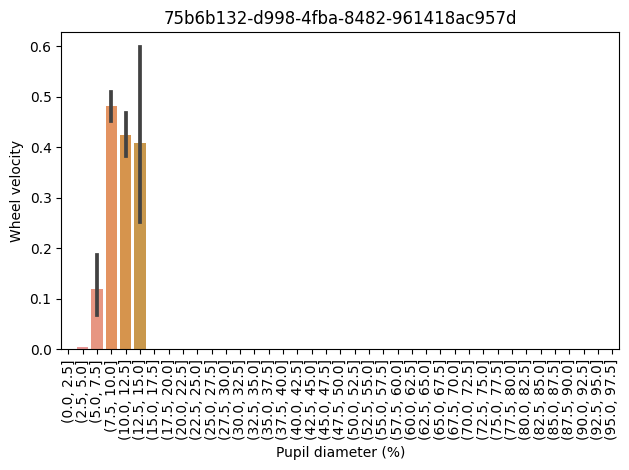

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


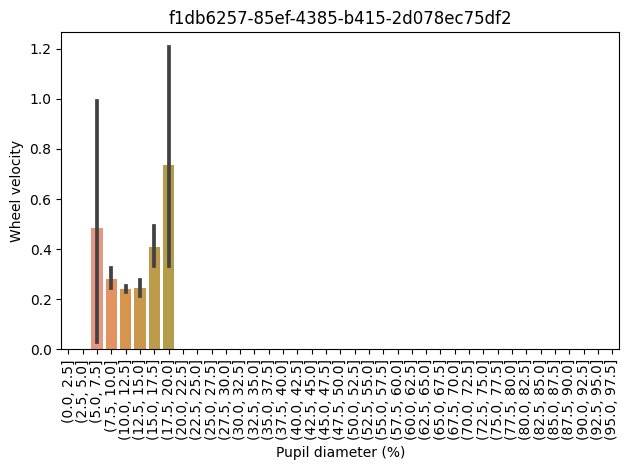

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


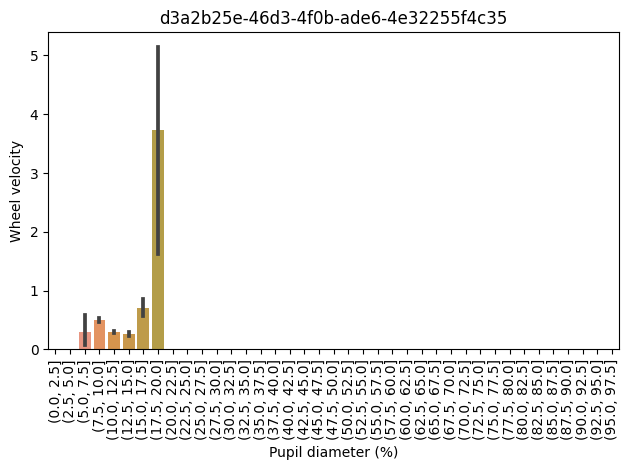

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


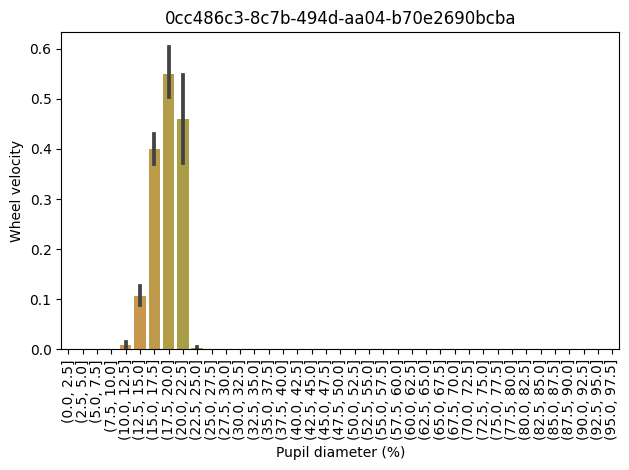

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


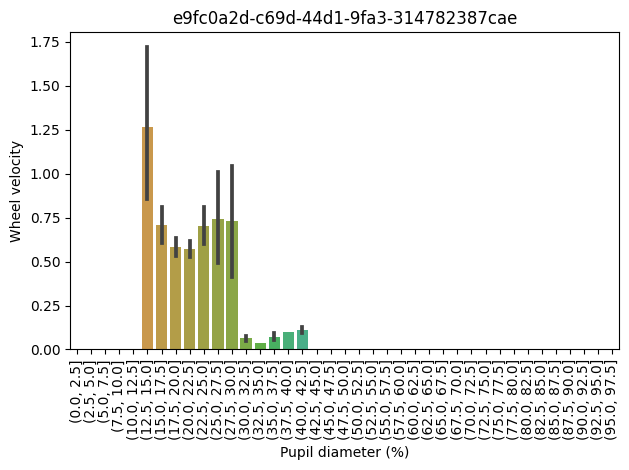

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


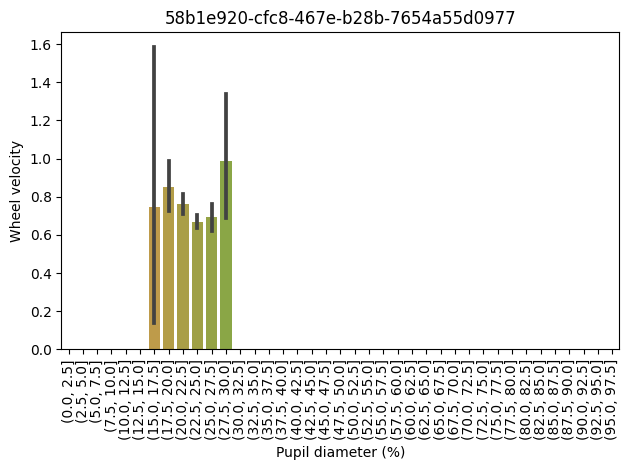

In [13]:
# Loop over sessions

for s, session in enumerate(pass_qc):

    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    #session_length = list(session_trials['stimOff_times'][-1:])[0]
    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    #if np.sum(np.isnan(onsets)) < 5:
    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        # Bin data on both axes
        bin_edges = np.arange(0, 100, 2.5)
        data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

        #data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
        #data_df = data_df.reset_index(level=[0])

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot per session
        sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
        plt.xlabel('Pupil diameter (%)')
        plt.ylabel('Wheel velocity')
        plt.title(session)
        plt.xticks(rotation=90)
        
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

In [14]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats
from scipy import signal

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [15]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

# Parameters
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


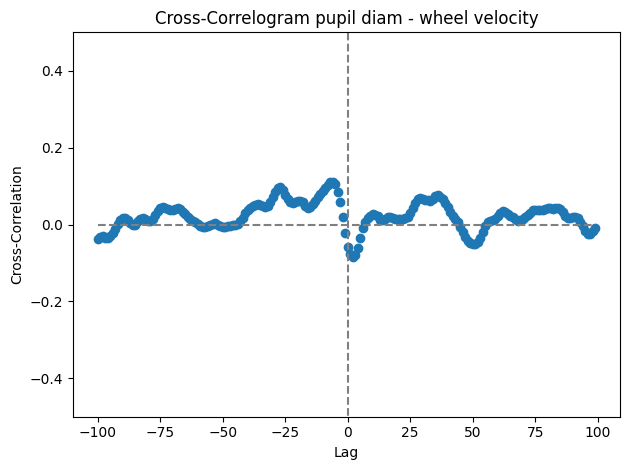

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


ValueError: Bin edges must be unique: array([ 110.56397583,  113.91744045,  128.90040867,  145.76332221,
        149.73009216,  170.34999663,  174.78298662,  179.03312823,
        182.87941023,  186.59997147,  190.79631846,  212.82901497,
        216.89890794,  219.71595954,  234.91193979,  237.91557273,
        242.84511306,  246.09875433,  249.14881596,  253.77831963,
        266.82808119,  272.34486279,  277.48131576,  287.32803099,
        294.18121227,  304.2279075 ,  315.27756909,  319.53074373,
        332.21074227,  335.34759522,  338.16421353,  341.18081184,
        350.92747041,  356.38085835,  378.82658022,  387.0932868 ,
        396.27993471,  402.51327798,  409.07605497,  412.04282493,
        417.84257823,  434.66276271,  439.64579769,  451.50891126,
        462.34216116,  480.94186767,  486.24210426,  494.71159056,
        505.09528542,  510.06162207,  521.99142897,  532.0411239 ,
        535.9244022 ,  551.92743507,  555.3941217 ,  566.92780155,
        580.37379015,  584.99032845,  591.27693306,  595.40702001,
        604.59373458,  619.07335314,  623.03965647,  627.65992773,
        632.74348599,  639.92296797,  648.10968255,  656.20617282,
        660.30569616,  670.4759457 ,  684.05918724,  692.7423855 ,
        697.27213248,  714.87190566,  718.92493365,  723.65836026,
        727.48851054,  731.62143054,  740.64176175,  744.07505172,
        750.30836166,  767.07451821,  780.6409281 ,  789.65432667,
        796.25739963,  802.9370316 ,  808.2871632 ,  820.47031143,
        831.07368432,  836.23683462,  847.0866162 ,  852.1567758 ,
        857.24003409,  863.40301773,  868.47284403,  873.96952764,
        884.55276921,  902.12257872,  909.08551569,  918.10588023,
        922.36858725,  928.06881717,  933.35542179,  938.53890339,
        947.23883331,  963.68848818,  966.53850315,  982.25119839,
        992.45104497,  995.3544546 , 1002.28439487, 1013.60449608,
       1019.21726808, 1026.18410466, 1037.68385457, 1042.43744583,
       1049.62022748, 1054.6871874 , 1063.83353934, 1069.76651265,
       1074.28646061, 1085.21670081, 1100.60282871, 1105.81954032,
       1110.93629526, 1124.23233219, 1129.10257845, 1132.50247176,
       1145.43537834, 1152.09871194, 1160.11884318, 1176.18177006,
       1185.4984383 , 1196.83140489, 1199.93472786, 1210.43474442,
       1215.71801604, 1221.19776801, 1224.63135795, 1237.23069789,
       1240.19743452, 1247.14750611, 1251.86696745, 1258.14707271,
       1267.51366929, 1270.70035059, 1287.46700709, 1298.01661869,
       1308.81323892, 1320.86673345, 1324.57972878, 1328.86596678,
       1332.79960671, 1336.76601003, 1340.84933499, 1343.89949661,
       1349.24592858, 1353.26579322, 1356.49590351, 1359.62905683,
       1362.74911146, 1369.49913639, 1372.74584502, 1384.63208961,
       1390.61219154, 1404.94485813, 1412.79857268, 1416.94839099,
       1421.04471465, 1424.14807095, 1437.82790283, 1447.34801739,
       1452.04791402, 1456.87783098, 1465.76060928, 1468.87739757,
       1478.73117876, 1484.7641754 , 1490.2139637 , 1505.74367724,
       1524.24712671, 1528.51326672, 1532.52999834, 1539.71314662,
       1551.47980317, 1557.82640178, 1563.69648138, 1568.71297968,
       1574.79277164, 1579.47590328, 1585.21272954, 1589.51229954,
       1597.02898113, 1601.55879477, 1604.62545474, 1611.82883433,
       1624.01168259, 1628.84189952, 1632.25845783, 1646.35824771,
       1653.41167563, 1660.97441928, 1667.07790887, 1671.0245475 ,
       1677.40780911, 1692.44437197, 1698.71071194, 1708.84046553,
       1712.19089712, 1716.42780672, 1719.82376709, 1728.12380367,
       1732.27372197, 1743.12337023, 1746.80656854, 1753.10983815,
       1756.12340343, 1760.25642342, 1766.43963837, 1773.33961497,
       1783.94322117, 1791.89275947, 1799.44277106, 1805.28925302,
       1814.15953257, 1819.12553592, 1824.97225119, 1828.4088075 ,
       1834.39200912, 1838.60535441, 1845.98861601, 1853.00488098,
       1863.52519551, 1871.93822079, 1893.49149858, 1901.13790053,
       1904.55465882, 1908.97425015, 1915.95408543, 1923.10790331,
       1927.35751164, 1940.65384854, 1944.59042151, 1949.92358814,
       1955.9533851 , 1961.94035301, 1969.23688995, 1974.43673658,
       1983.02357781, 1989.5066961 , 1994.88642474, 1998.33654636,
       2002.64021595, 2008.98611463, 2013.90612258, 2017.73960586,
       2020.96941618, 2023.95618414, 2039.78556771, 2046.53559264,
       2049.50606223, 2054.65591386, 2063.58918711, 2069.75197077,
       2081.90475537, 2085.62161698, 2090.42200356, 2097.77196849,
       2105.4884301 , 2109.40490508, 2113.85156037, 2128.13439861,
       2135.01767688, 2140.10106849, 2144.08760313, 2149.50099507,
       2153.33741139, 2158.78380003, 2162.66741163, 2166.68360997,
       2171.8337949 , 2180.60401779, 2188.21698975, 2193.72063933,
       2206.58675259, 2216.73647085, 2223.73300446, 2231.33307771,
       2236.30291401, 2245.18272594, 2252.66941053, 2258.0658375 ,
       2269.24881909, 2275.09886736, 2281.78203231, 2289.94861557,
       2293.06913682, 2299.21832184, 2302.44863211, 2306.58191874,
       2311.45186503, 2315.61511533, 2318.50165998, 2321.76833328,
       2326.31854488, 2331.38497152, 2355.651078  , 2361.55088796,
       2368.86395658, 2376.2976798 , 2380.26771609, 2388.26398305,
       2394.71767095, 2398.51395795, 2403.28414755, 2407.53405585,
       2410.61364786, 2413.65024417, 2417.16329283, 2423.16672576,
       2427.74663439, 2434.43356563, 2439.16302597, 2449.0160739 ,
       2452.77976416, 2456.53315545, 2459.54625411, 2463.2996454 ,
       2468.23285203, 2475.87918732, 2480.72913561, 2485.61238057,
       2489.6460105 , 2495.16255879, 2499.56221878, 2505.83202507,
       2512.14902664, 2520.11556324, 2523.22835193, 2531.17865682,
       2534.54505348, 2544.9784767 , 2550.06510132, 2557.58168292,
       2562.49459158, 2566.29461154, 2577.09446478, 2581.13146104,
       2586.54441969, 2591.17765632, 2594.81102628, 2599.33124088,
       2603.61037959, 2608.71450246, 2616.19748742, 2624.58081567,
       2629.02680436, 2639.4470289 , 2642.9800089 , 2647.86022083,
       2654.04343578, 2658.57634911, 2664.67647237, 2677.61294526,
       2691.54265215, 2695.34630508, 2704.72560039, 2708.62614363,
       2717.44252857, 2721.09572988, 2724.52542021, 2730.31270809,
       2737.55891673, 2743.99543968, 2750.67533829, 2755.22508327,
       2769.30824148, 2777.29160973, 2781.89141637, 2787.32800599,
       2792.77819425, 2805.6410745 , 2809.14475743, 2815.89464904,
       2821.76072904, 2827.807191  , 2832.6407076 , 2836.82408922,
       2845.99400547, 2851.04036745, 2855.89364874, 2859.81039036,
       2867.6602053 , 2872.90664727, 2877.47339055, 2881.62667518,
       2886.2730105 , 2891.33980377, 2895.77629341, 2899.86008499,
       2910.35976825, 2914.17618657, 2918.67257022, 2929.22598144,
       2936.39246472, 2940.64250634, 2945.27590962, 2950.48902159,
       2955.48902154, 2961.77529285, 2969.33860311, 2973.47548938,
       2976.65860437, 2985.4750893 ,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [16]:
for s, session in enumerate(list(pass_qc)):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    # Initialize dataframe
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
    pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
    wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

    pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

    # Merge data
    all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
    all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

    # Remove wheel disp (was used just to get onset times alignment with bins)
    data_df = all_metrics.dropna().drop_duplicates()

    data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

    # Plot
    x = data_df['pupil_diameter']
    y = data_df['avg_wheel_vel']

    # Calculate the lag values corresponding to the cross-correlation
    lags = np.arange(-100, 100)

    # Compute the cross-correlation using np.correlate
    cross_correlation = np.zeros(len(lags)) * np.nan
    len_timeseries = len(x)
    for l, lag in enumerate(lags):
        if lag < 0:
            x_chunk = np.array(x[-lag:])
            y_chunk = np.array(y[:lag])
        elif lag == 0:
            x_chunk = np.array(x)
            y_chunk = np.array(y)
        elif lag > 0:
            x_chunk = np.array(x[0:-lag])
            y_chunk = np.array(y[lag:])
        cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
        #np.sum(x_chunk * y[lag-lag:len(x_chunk)]) / ((len_timeseries-lag)* np.std(x_chunk) * np.std(y[lag-lag:len(x_chunk)]))

    # Plot the cross-correlation
    import matplotlib.pyplot as plt
    plt.scatter(lags, cross_correlation)
    plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
    plt.vlines(0, -1, 1, color='gray', linestyles='--')
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title('Cross-Correlogram pupil diam - wheel velocity')
    plt.ylim([-.5, .5])
            
    plt.tight_layout()

    # Save the plot as a PNG file
    #plt.savefig(str(save_path + session + '.png'), format='png')

    # Display the plot
    plt.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


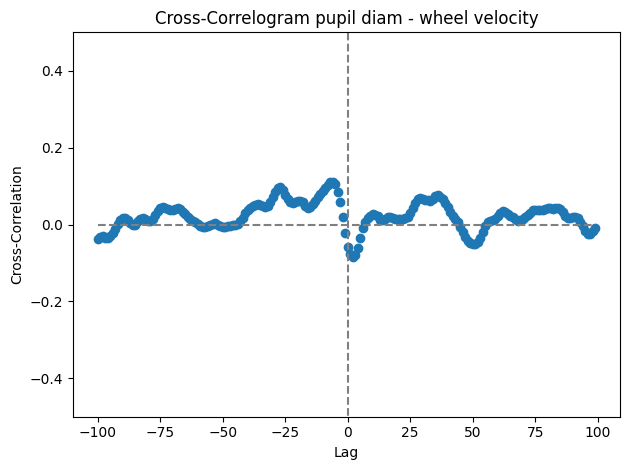

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


KeyboardInterrupt: 

In [17]:
for s, session in enumerate(list(pass_qc)):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot
        x = data_df['pupil_diameter']
        y = data_df['avg_wheel_vel']

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-100, 100)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(y[:lag])
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(y)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(y[lag:])
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

        # Plot the cross-correlation
        plt.scatter(lags, cross_correlation)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag')
        plt.ylabel('Cross-Correlation')
        plt.title('Cross-Correlogram pupil diam - wheel velocity')
        plt.ylim([-.5, .5])
                
        plt.tight_layout()

        # Save the plot as a PNG file
        #plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


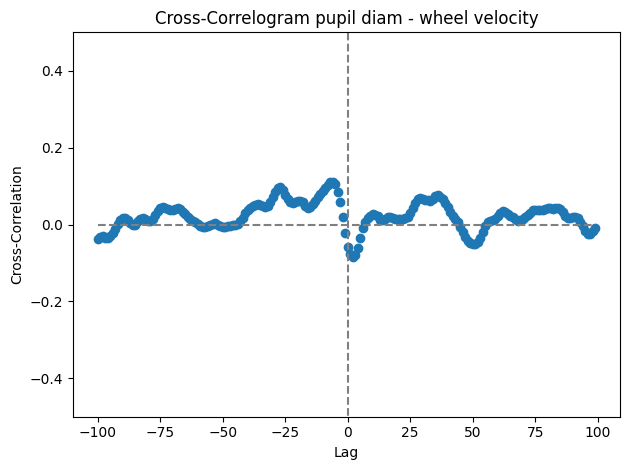

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d32876dd-8303-4720-8e7e-20678dc2fd71


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


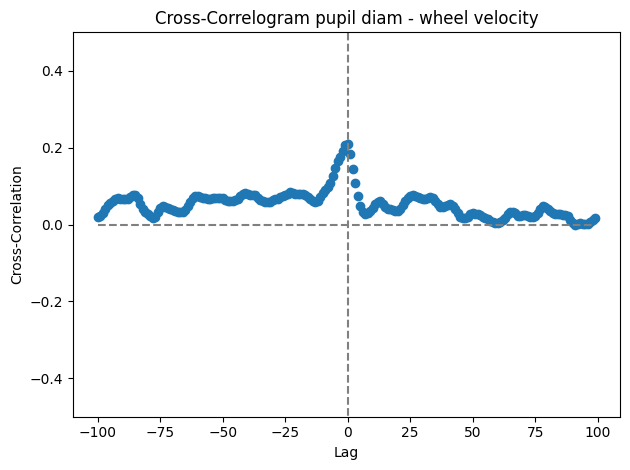

local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [01:04<00:00, 577kB/s] 
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:29<00:00, 1.27MB/s]


288bfbf3-3700-4abe-b6e4-130b5c541e61


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


fc43390d-457e-463a-9fd4-b94a0a8b48f5


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


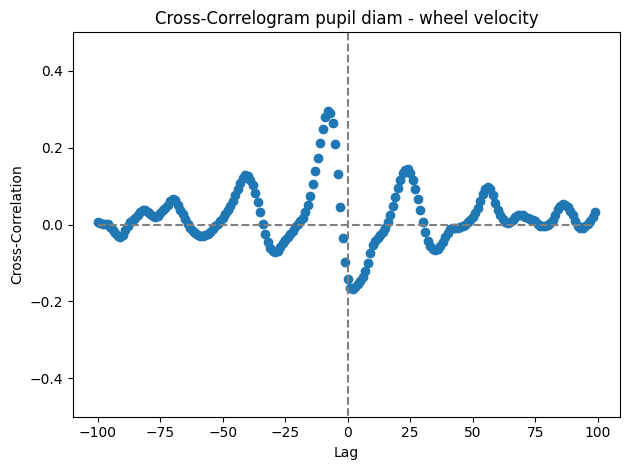

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


0a018f12-ee06-4b11-97aa-bbbff5448e9f


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


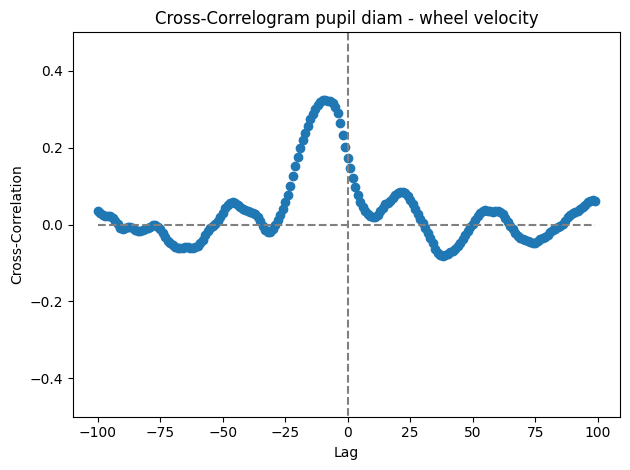

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


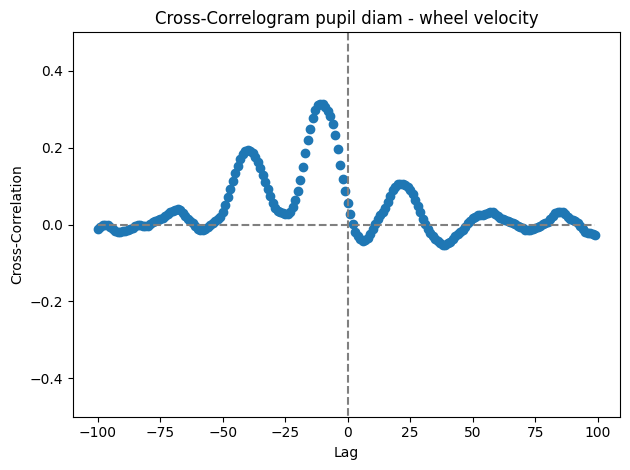

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


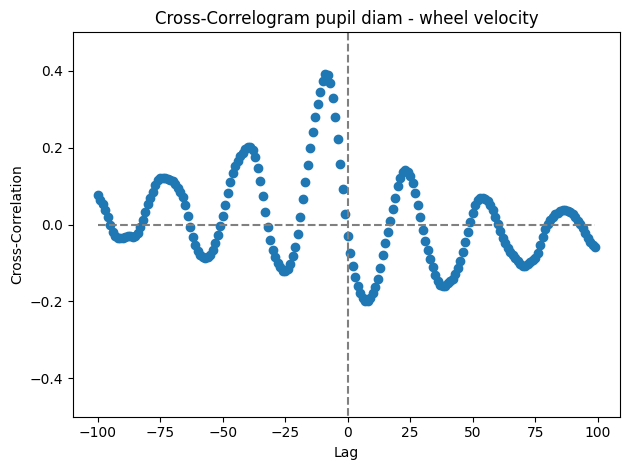

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


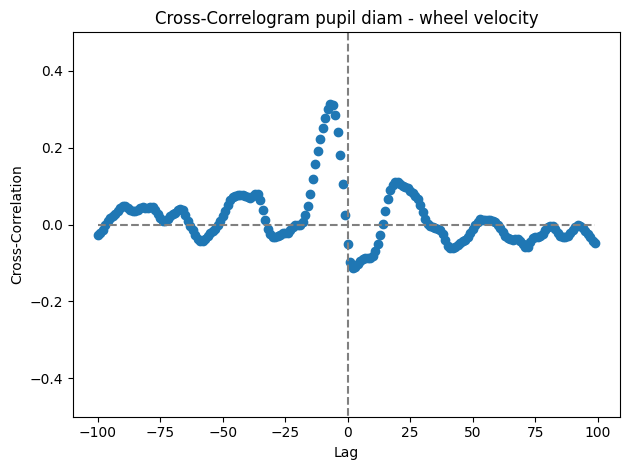

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


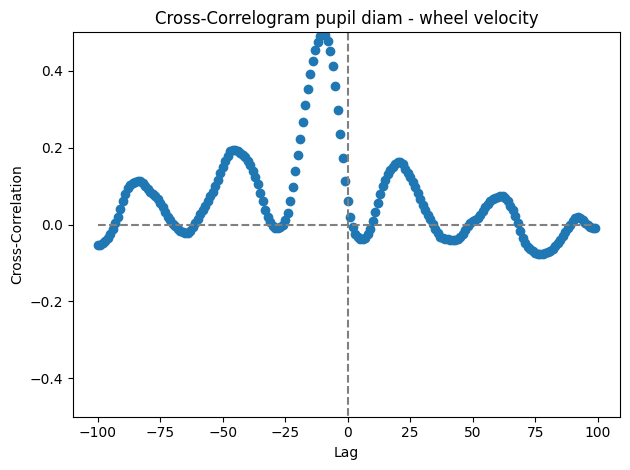

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


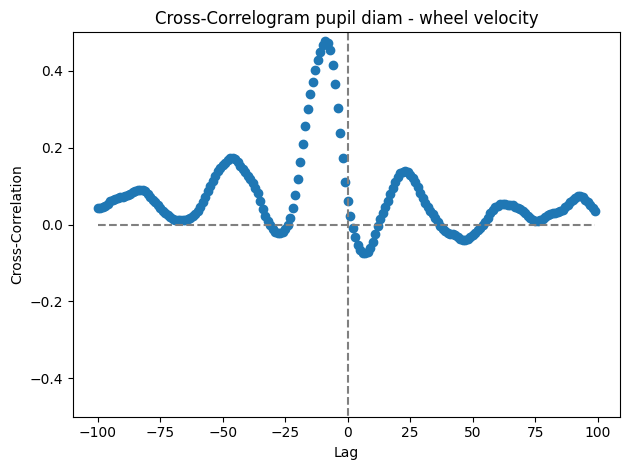

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


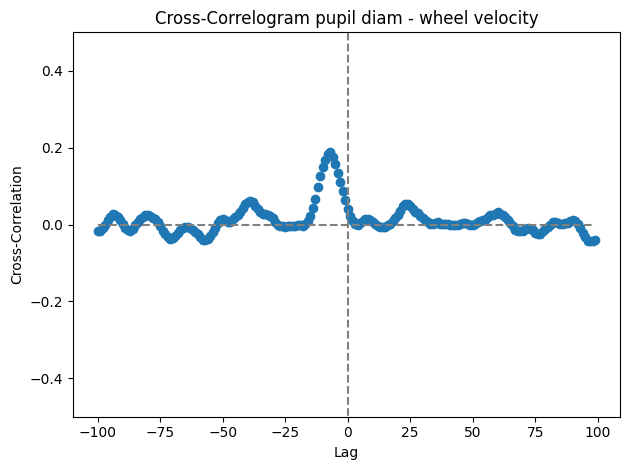

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


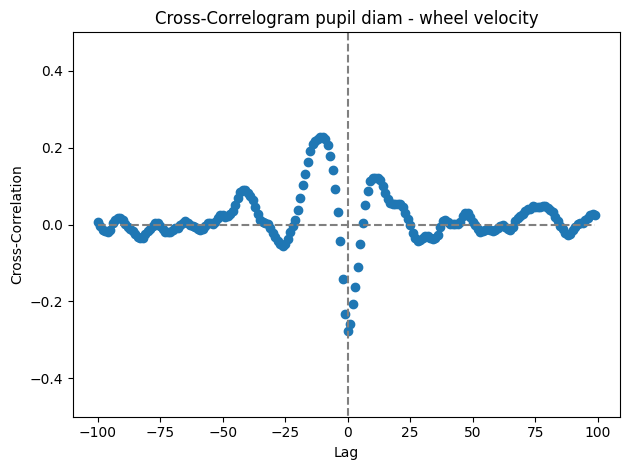

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


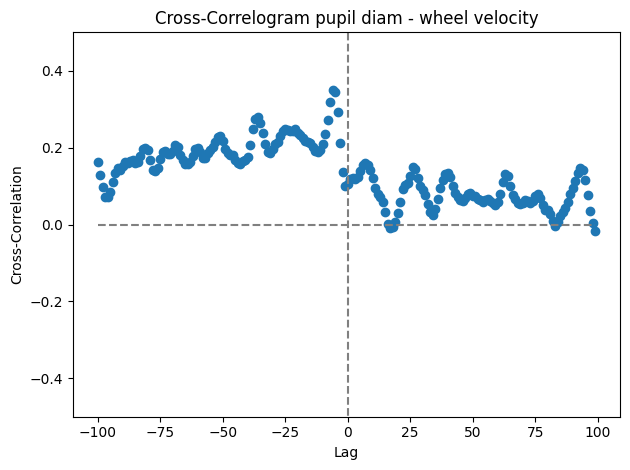

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


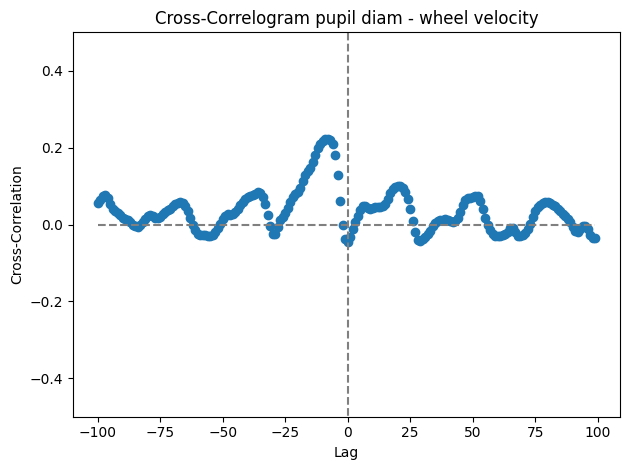

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


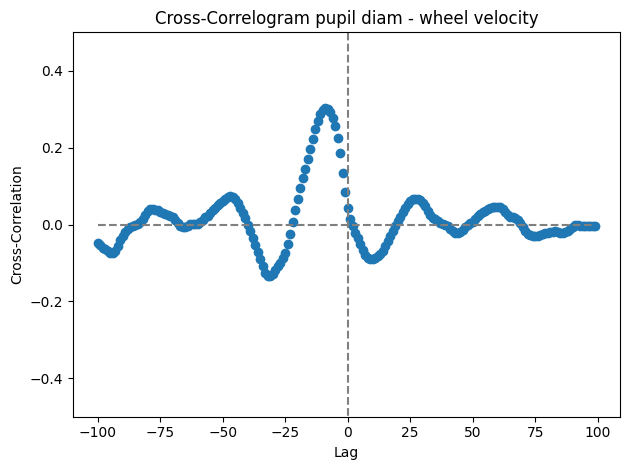

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


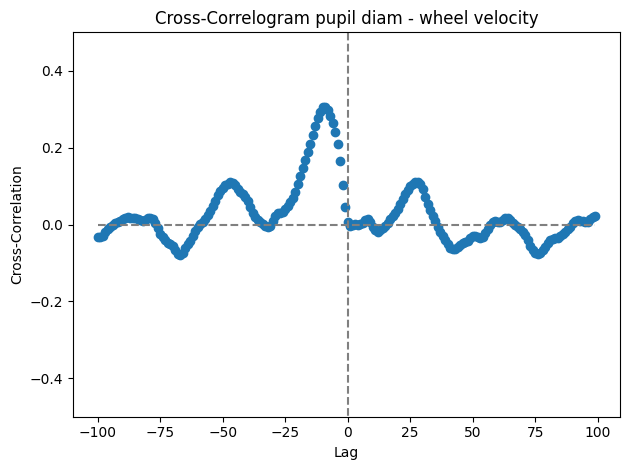

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


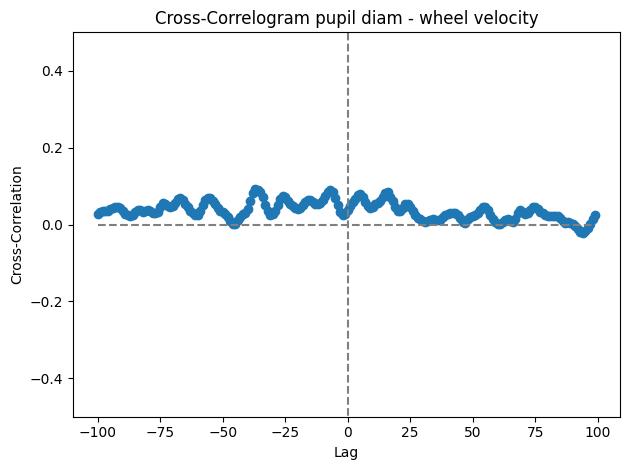

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


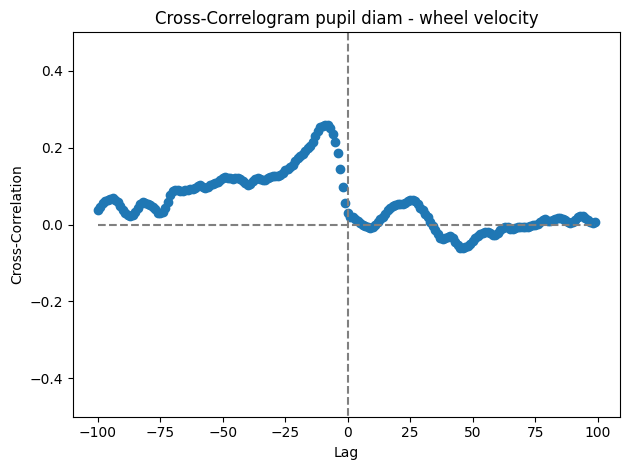

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


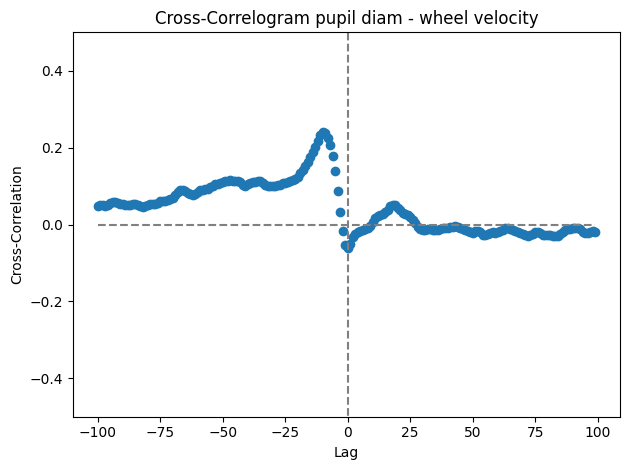

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


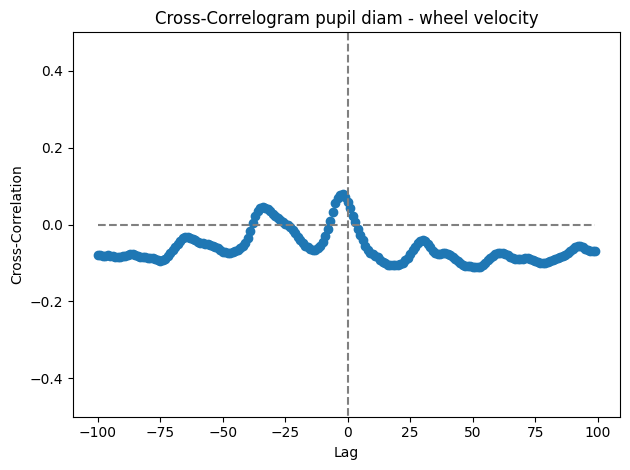

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


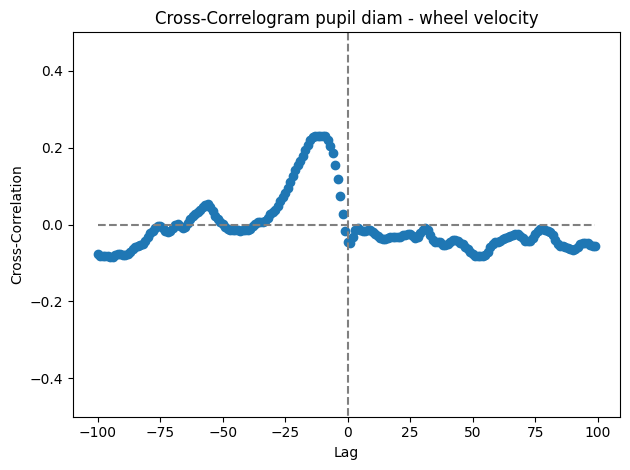

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


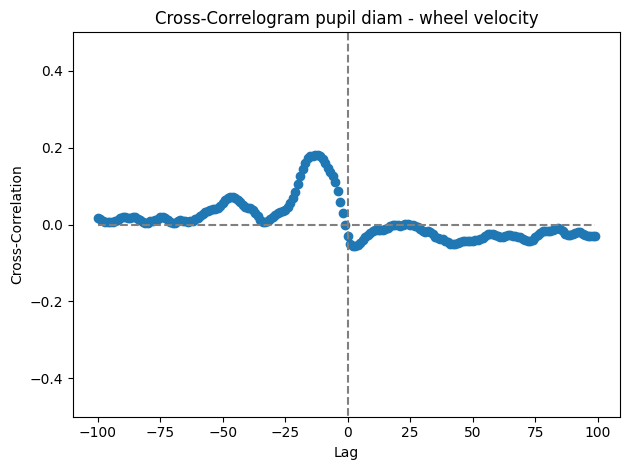

In [18]:
for s, session in enumerate(list(pass_qc)):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot
        x = data_df['pupil_diameter']
        y = data_df['avg_wheel_vel']

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-100, 100)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(y[:lag])
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(y)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(y[lag:])
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

        # Plot the cross-correlation
        plt.scatter(lags, cross_correlation)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag')
        plt.ylabel('Cross-Correlation')
        plt.title('Cross-Correlogram pupil diam - wheel velocity')
        plt.ylim([-.5, .5])
                
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

In [19]:
# Pupil diameter and paw speed

for s, session in enumerate(list(pass_qc)):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', True)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed_X = left_p_speeds['left'][1]

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = pupil[['Bin', 'pupil_diameter']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_p_speed_X[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot
        x = data_df['pupil_diameter']
        y = data_df['avg_wheel_vel']

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-100, 100)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(y[:lag])
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(y)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(y[lag:])
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

        # Plot the cross-correlation
        plt.scatter(lags, cross_correlation)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag')
        plt.ylabel('Cross-Correlation')
        plt.title('Cross-Correlogram pupil diam - wheel velocity')
        plt.ylim([-.5, .5])
                
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.23M/4.23M [00:02<00:00, 1.58MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-40/2021-04-16/002/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 81.5M/81.5M [00:39<00:00, 2.08MB/s]


f359281f-6941-4bfd-90d4-940be22ed3c3


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d32876dd-8303-4720-8e7e-20678dc2fd71


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.65M/5.65M [00:04<00:00, 1.40MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-46/2021-06-23/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 90.9M/90.9M [00:43<00:00, 2.10MB/s]


72982282-e493-45ee-87ce-aa45cb3a3ec1


local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:11<00:00, 3.39MB/s]
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
local md5 mismatch on dataset: angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt
/Users/ineslaranjeira/Downloads/FlatIron/angelakilab/Subjects/NYU-47/2021-06-24/003/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 37.5M/37.5M [00:14<00:00, 2.65MB/s]


288bfbf3-3700-4abe-b6e4-130b5c541e61


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


fc43390d-457e-463a-9fd4-b94a0a8b48f5


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_rightCamera.times.npy: 100%|██████████| 6.89M/6.89M [00:02<00:00, 2.95MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 114M/114M [00:23<00:00, 4.89MB/s] 


2e6e179c-fccc-4e8f-9448-ce5b6858a183


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


0a018f12-ee06-4b11-97aa-bbbff5448e9f


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.39M/4.39M [00:01<00:00, 2.35MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS096/2022-06-21/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 83.9M/83.9M [00:16<00:00, 5.13MB/s]


a2701b93-d8e1-47e9-a819-f1063046f3e7


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.59M/4.59M [00:01<00:00, 2.50MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_013/2020-03-12/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 77.8M/77.8M [00:18<00:00, 4.13MB/s]


e535fb62-e245-4a48-b119-88ce62a6fe67


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.63M/5.63M [00:03<00:00, 1.43MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_014/2020-07-19/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 96.4M/96.4M [00:25<00:00, 3.81MB/s]


b39752db-abdb-47ab-ae78-e8608bbf50ed


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.98M/4.98M [00:02<00:00, 1.66MB/s]
/Users/ineslaranjeira/Downloads/FlatIron/danlab/Subjects/DY_016/2020-09-11/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 85.8M/85.8M [00:27<00:00, 3.14MB/s]


5339812f-8b91-40ba-9d8f-a559563cc46b


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


d23a44ef-1402-4ed7-97f5-47e9a7a504d9


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Restarted iblenv (Python 3.10.12)

In [1]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [2]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

In [3]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

In [4]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [5]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats
from scipy import signal

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin

In [6]:
one = ONE()

# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))

# Parameters
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'
save_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Exported figures/'

In [7]:
pass_qc

21     f359281f-6941-4bfd-90d4-940be22ed3c3
25     d32876dd-8303-4720-8e7e-20678dc2fd71
26     72982282-e493-45ee-87ce-aa45cb3a3ec1
30     288bfbf3-3700-4abe-b6e4-130b5c541e61
31     fc43390d-457e-463a-9fd4-b94a0a8b48f5
64     2e6e179c-fccc-4e8f-9448-ce5b6858a183
112    0a018f12-ee06-4b11-97aa-bbbff5448e9f
131    a2701b93-d8e1-47e9-a819-f1063046f3e7
154    e535fb62-e245-4a48-b119-88ce62a6fe67
161    b39752db-abdb-47ab-ae78-e8608bbf50ed
162    5339812f-8b91-40ba-9d8f-a559563cc46b
163    d23a44ef-1402-4ed7-97f5-47e9a7a504d9
166    251ece37-7798-477c-8a06-2845d4aa270c
179    9a6e127b-bb07-4be2-92e2-53dd858c2762
183    58c4bf97-ec3b-45b4-9db4-d5d9515d5b00
185    8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef
187    f27e6cd6-cdd3-4524-b8e3-8146046e2a7d
221    4aa1d525-5c7d-4c50-a147-ec53a9014812
222    9b5a1754-ac99-4d53-97d3-35c2f6638507
262    75b6b132-d998-4fba-8482-961418ac957d
271    f1db6257-85ef-4385-b415-2d078ec75df2
272    d3a2b25e-46d3-4f0b-ade6-4e32255f4c35
311    0cc486c3-8c7b-494d-aa04-b

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


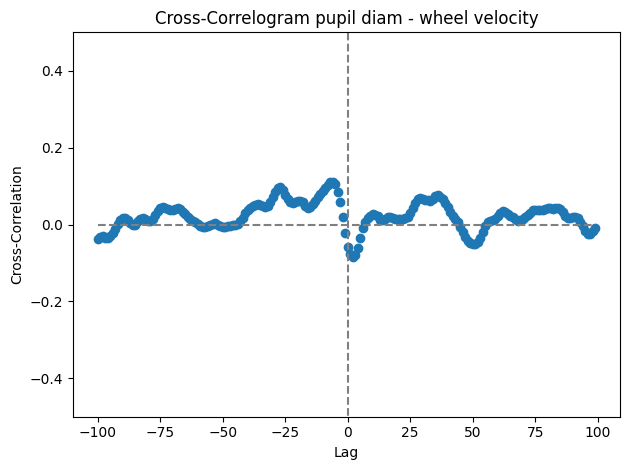

In [8]:
# Pupil diameter and wheel velocity
for s, session in enumerate(list(pass_qc)[0:1]):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot
        x = data_df['pupil_diameter']
        y = data_df['avg_wheel_vel']

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-100, 100)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(y[:lag])
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(y)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(y[lag:])
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

        # Plot the cross-correlation
        plt.scatter(lags, cross_correlation)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag')
        plt.ylabel('Cross-Correlation')
        plt.title('Cross-Correlogram pupil diam - wheel velocity')
        plt.ylim([-.5, .5])
                
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

In [9]:
all_metrics

,Bin,avg_wheel_vel,Onset times,pupil_diameter
0,0.0,-0.001116,NaN,NaN
1,0.0,-0.001116,NaN,NaN
2,0.0,-0.001116,NaN,NaN
3,0.0,-0.001116,NaN,NaN
4,0.0,-0.001116,NaN,NaN
...,...,...,...,...
3541452,NaN,NaN,NaN,NaN
3541453,NaN,NaN,NaN,NaN
3541454,NaN,NaN,NaN,NaN
3541455,NaN,NaN,NaN,NaN


In [10]:
s

0

In [11]:
#### Pupil diameter and paw speed ####

for s, session in enumerate(list(pass_qc)[0:1]):
    # Trials data
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

    try: # TODO: need to solve individual issues and remove try
        # Initialize dataframe
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', True)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed_X = left_p_speeds['left'][1]

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = pupil[['Bin', 'pupil_diameter']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
        all_metrics = all_metrics.merge(left_p_speed_X[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

        # Plot
        x = data_df['pupil_diameter']
        y = data_df['avg_wheel_vel']

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-100, 100)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(y[:lag])
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(y)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(y[lag:])
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic

        # Plot the cross-correlation
        plt.scatter(lags, cross_correlation)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag')
        plt.ylabel('Cross-Correlation')
        plt.title('Cross-Correlogram pupil diam - wheel velocity')
        plt.ylim([-.5, .5])
                
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig(str(save_path + session + '.png'), format='png')

        # Display the plot
        plt.show()
    except:
        print(session)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


f359281f-6941-4bfd-90d4-940be22ed3c3


In [12]:
session

'f359281f-6941-4bfd-90d4-940be22ed3c3'

In [13]:
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = prepro(session_trials.to_df())

    # Wheel
    wheel = one.load_object(session, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

    # Pupil diameter
    pupil_dia_raw, pupil_dia_smooth, _, _ = (
        get_raw_and_smooth_position(session, video_type, ephys=True, 
                                    position_function=get_pupil_diameter))
    pupil_t, XYs = get_dlc_XYs(session, view=video_type, likelihood_thresh=0.9)

    session_length = len(session_trials['stimOff_times'])
    n_bins = int(np.floor(session_length/bin_size))
    onsets = session_trials['stimOn_times']

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [14]:
        pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
        #wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

        # Left paw velocity
        left_p_speeds = keypoint_speed(session, True, 'paw_r', True)
        left_p_times = left_p_speeds['left'][0][1:]
        left_p_speed_X = left_p_speeds['left'][1]

        pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

        # Merge data
        all_metrics = pupil[['Bin', 'pupil_diameter']].merge(left_p_speed_X[['Bin', 'pupil_diameter']], on='Bin', how='outer')

        # Remove wheel disp (was used just to get onset times alignment with bins)
        data_df = all_metrics.dropna().drop_duplicates()

        #data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices